In [1]:
# importing packages

import numpy as np
import os
import time
from dask import dataframe as dd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
import glob
import sys
import sklearn.neighbors._base
import vitaldb
import itertools

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

In [3]:
def getRootDir():
    """
    Get root folder directory
    :return: root folder directory
    :rtype: path
    """
    rootdir = os.path.abspath(os.curdir)

    return rootdir
rootdir = getRootDir()
rootdir

'/Users/tselanna/Desktop/Code'

In [4]:
# Import dataset
df = glob.glob(os.path.join(
        rootdir, 'TOSHIBA_HDD/2022_07_15T18_01_25_ANALYSIS_DF_44var.csv'))
df = pd.read_csv(df[0], dtype={"Solar8000/BT": float})

In [6]:
# shrink dataset  
ids = df.caseid.unique()


In [7]:
# Did not use this after all, train test split is performed later in the code
train = ids[0:484]
print(len(train))
test = ids[484:]
print(len(test))

484
120


In [8]:
test

array([5050, 5068, 5086, 5087, 5115, 5128, 5130, 5139, 5140, 5167, 5187,
       5196, 5198, 5206, 5211, 5215, 5221, 5229, 5249, 5252, 5263, 5279,
       5284, 5293, 5295, 5297, 5318, 5335, 5345, 5361, 5378, 5387, 5395,
       5400, 5402, 5423, 5465, 5469, 5494, 5506, 5509, 5516, 5523, 5540,
       5555, 5566, 5568, 5570, 5582, 5596, 5600, 5601, 5627, 5631, 5639,
       5644, 5658, 5672, 5700, 5716, 5731, 5734, 5737, 5741, 5742, 5756,
       5764, 5786, 5798, 5821, 5828, 5834, 5879, 5881, 5888, 5900, 5911,
       5913, 5927, 5935, 5949, 5960, 5968, 5984, 6001, 6023, 6036, 6045,
       6059, 6112, 6116, 6118, 6123, 6133, 6137, 6146, 6181, 6210, 6214,
       6218, 6225, 6226, 6231, 6232, 6241, 6253, 6263, 6265, 6272, 6294,
       6316, 6317, 6321, 6325, 6340, 6352, 6356, 6358, 6360, 6385])

In [9]:
isin = df.loc[df['caseid'].isin(test)]
isin = isin[['Solar8000/NIBP_MBP']]
isin

,Solar8000/NIBP_MBP
1852853,94.0
1852854,94.0
1852855,94.0
1852856,94.0
1852857,94.0
...,...
2370391,83.0
2370392,83.0
2370393,83.0
2370394,83.0


## Preprocessing

In [7]:
MINUTES_AHEAD = 5  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 100  # Batch size for learning
MAX_CASES = 604  # Maximum number of cases for this example

In [8]:
caseids = set(df.caseid)
len(caseids)

604

In [9]:
# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure 

    a = df.loc[df.caseid.eq(caseid)]
    b = a[['Solar8000/NIBP_MBP']].values.tolist()
    mbps= list(itertools.chain.from_iterable(b))
    

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (150 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 150]
        segy = mbps[i + 150 + MINUTES_AHEAD * 30:i + 150 + MINUTES_AHEAD * 30 + 30]
        
        valid = True
        valid_mask.append(valid)
        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        c.append(caseid)
        
        if evt:
            case_event += 1
   
        if valid:
            case_sample += 1
            if evt:
                case_event += 1
    
    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 1...17 samples 0 (0.0 %) events
loading 4097...3746 samples 0 (0.0 %) events
loading 6146...7735 samples 2074 (26.8 %) events
loading 2054...5722 samples 1900 (33.2 %) events
loading 4110...3215 samples 1604 (49.9 %) events
loading 4114...1219 samples 0 (0.0 %) events
loading 2068...499 samples 68 (13.6 %) events
loading 21...5552 samples 0 (0.0 %) events
loading 4121...4410 samples 0 (0.0 %) events
loading 30...4875 samples 2482 (50.9 %) events
loading 2078...6945 samples 1088 (15.7 %) events
loading 2082...2030 samples 0 (0.0 %) events
loading 6181...7415 samples 530 (7.1 %) events
loading 2094...5655 samples 770 (13.6 %) events
loading 50...1815 samples 734 (40.4 %) events
loading 2100...3016 samples 796 (26.4 %) events
loading 2104...3709 samples 6 (0.2 %) events
loading 57...4610 samples 936 (20.3 %) events
loading 2105...3302 samples 90 (2.7 %) events
loading 2107...1784 samples 0 (0.0 %) events
loading 2108...1245 samples 0 (0.0 %) events
loading 2109...7072 samples 6368

In [51]:
range(0, len(mbps) - (150 + MINUTES_AHEAD * 30 + 30))

range(0, 4309)

## Splitting samples into training and testing dataset

In [10]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set test set 
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask]
train_y_valid = y[train_mask]
test_x_valid = x[test_mask]
test_y_valid = y[test_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'604cases 5ahead batchsize=100 total 2172256, train 1700013 (118274 events 7.0%), test 472243 (25022 events 5.3%)'

## Model building and training

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

2022-08-13 15:32:08.129995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
15301/15301 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.8931 - auc: 0.8536
Epoch 1: val_loss improved from inf to 0.26878, saving model to output/weights.hdf5
15301/15301 [==============================] - 1054s 69ms/step - loss: 0.5164 - accuracy: 0.8931 - auc: 0.8536 - val_loss: 0.2688 - val_accuracy: 0.8876 - val_auc: 0.8250
Epoch 2/100
15301/15301 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.8897 - auc: 0.8564
Epoch 2: val_loss improved from 0.26878 to 0.24526, saving model to output/weights.hdf5
15301/15301 [==============================] - 1805s 118ms/step - loss: 0.5112 - accuracy: 0.8897 - auc: 0.8564 - val_loss: 0.2453 - val_accuracy: 0.9054 - val_auc: 0.8257
Epoch 3/100
15301/15301 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.8886 - auc: 0.8567
Epoch 3: val_loss did not improve from 0.24526
15301/15301 [==============================] - 1761s 115ms/step - loss: 0.5106 - accuracy: 0.

2127

## Evaluation of the model performance

In [13]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [14]:
# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)



14758/14758 [==============================] - 247s 17ms/step
auroc=0.831, auprc=0.225 acc=0.931, F1=0.283, PPV=31.4, NPV=95.9, TN=433112, fp=14109, fn=18563, TP=6459


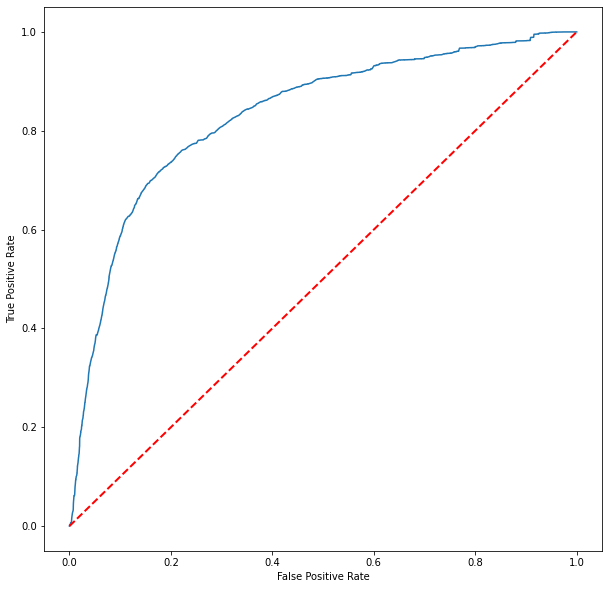

<function matplotlib.pyplot.show(close=None, block=None)>

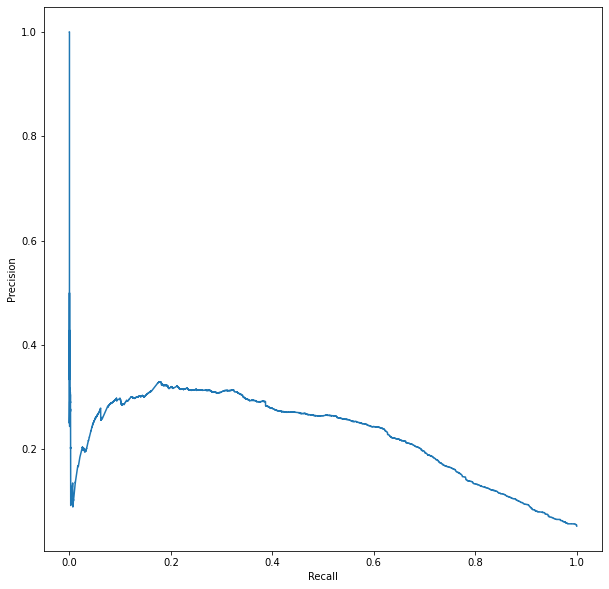

In [15]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig('{}/auroc.png'.format(tempdir))
# plt.close()
plt.show()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.savefig('{}/auprc.png'.format(tempdir))
# plt.close()
plt.show


## Plotting each case in the test dataset

43/43 [==============================] - 1s 13ms/step
Print error: 5068	0.06061649357769353	


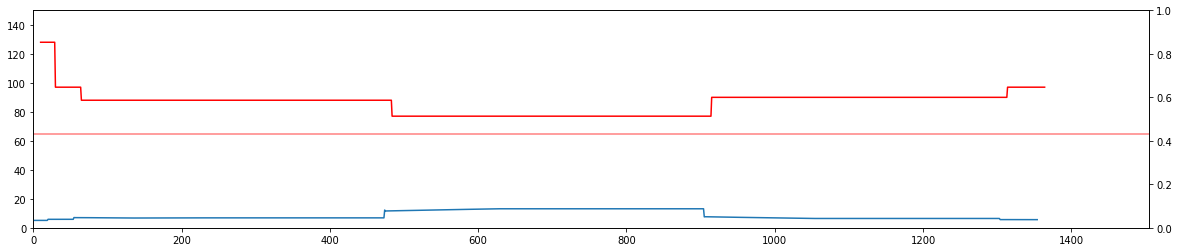

100/100 [==============================] - 1s 14ms/step
Print error: 5086	0.2576894611031433	


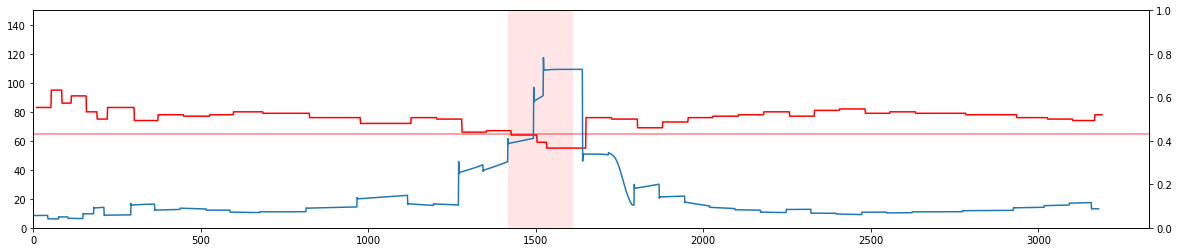

192/192 [==============================] - 3s 14ms/step
Print error: 5087	0.1695673247159581	


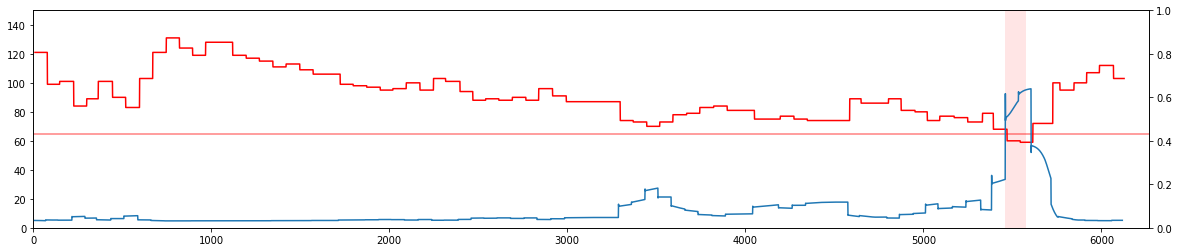

107/107 [==============================] - 1s 14ms/step
Print error: 5115	0.29568105839542463	


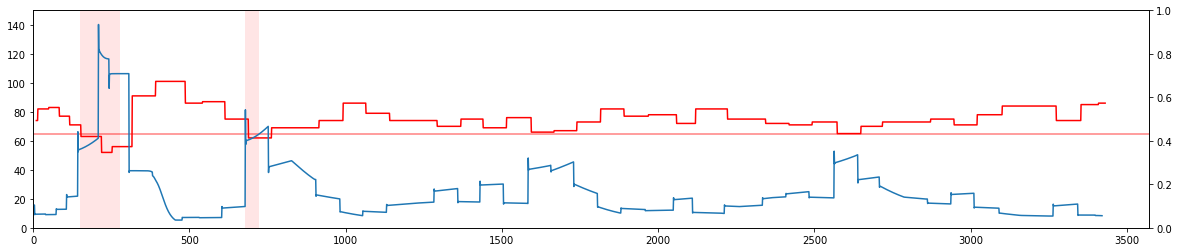

117/117 [==============================] - 2s 18ms/step
Print error: 5128	0.0586109930733938	


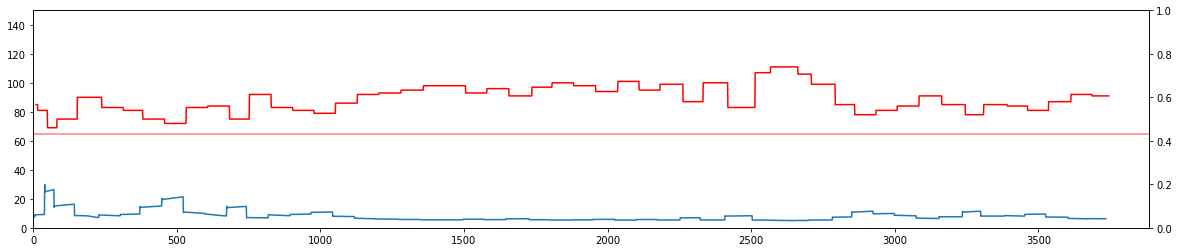

68/68 [==============================] - 1s 16ms/step
Print error: 5130	0.362331687558679	


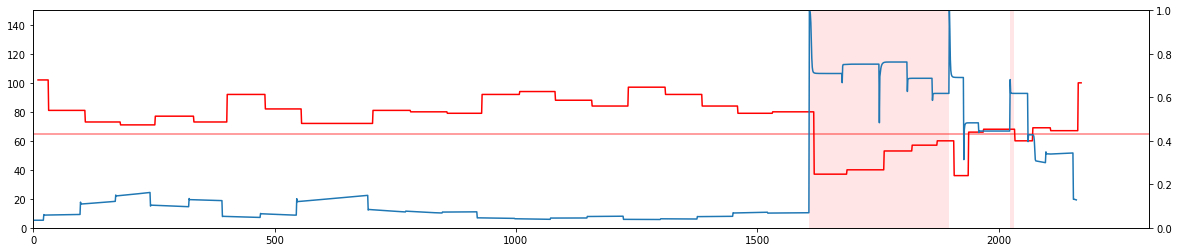

76/76 [==============================] - 1s 16ms/step
Print error: 5139	0.24099711929821563	


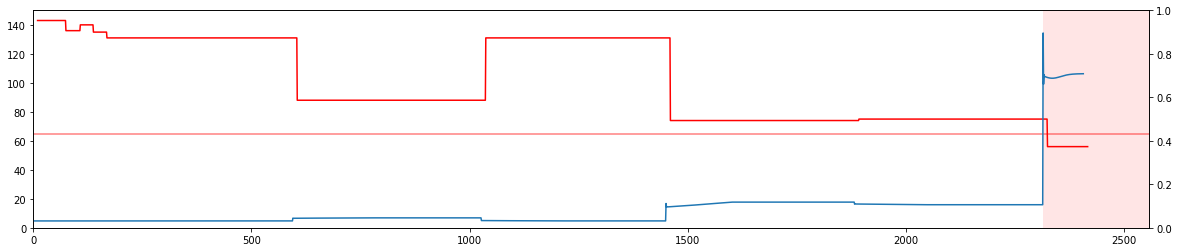

63/63 [==============================] - 1s 17ms/step
Print error: 5140	0.11818296107972487	


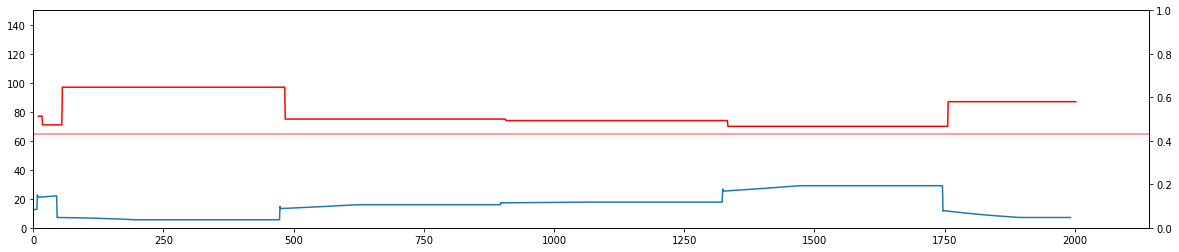

146/146 [==============================] - 2s 15ms/step
Print error: 5167	0.24600890377260198	


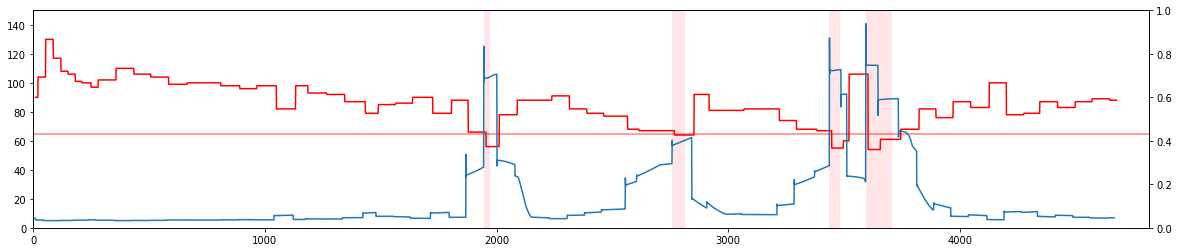

32/32 [==============================] - 1s 16ms/step
Print error: 5187	0.04815060488245043	


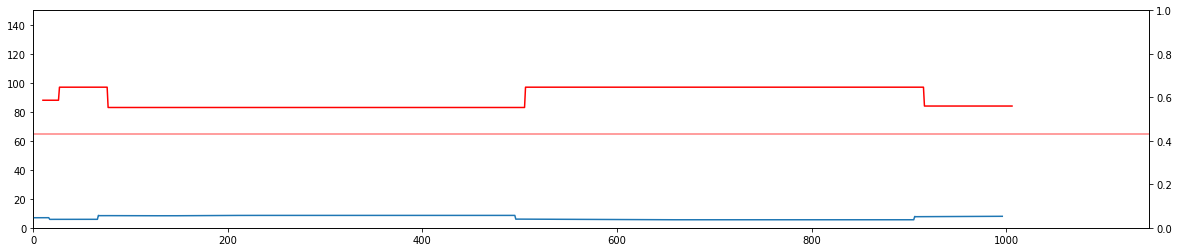

191/191 [==============================] - 3s 16ms/step
Print error: 5196	0.218260933620739	


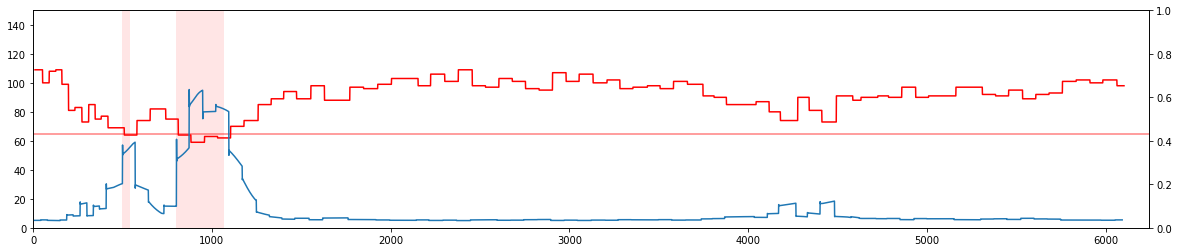

7/7 [==============================] - 0s 15ms/step
Print error: 5198	0.03377110101714886	


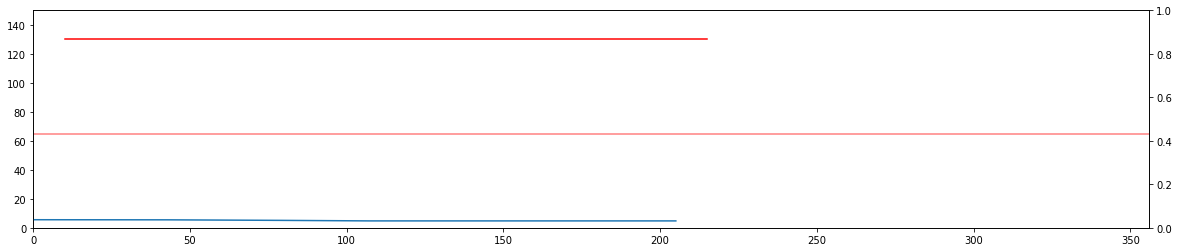

112/112 [==============================] - 1s 13ms/step
Print error: 5206	0.06974831370076494	


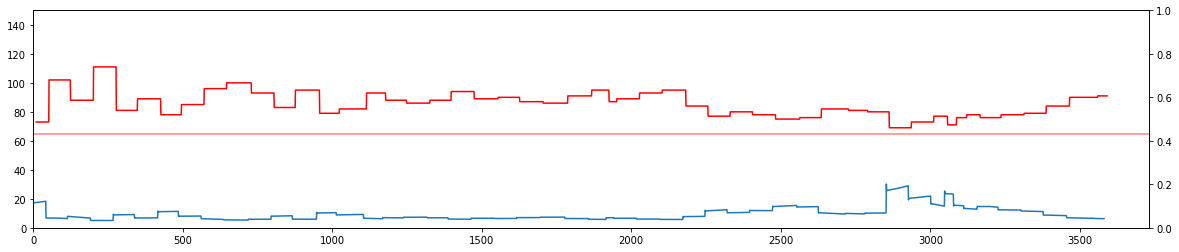

208/208 [==============================] - 3s 15ms/step
Print error: 5211	0.131839469579783	


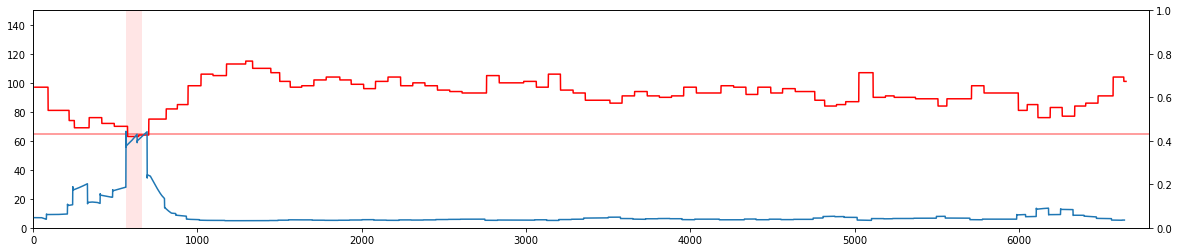

131/131 [==============================] - 2s 15ms/step
Print error: 5215	0.06461850896869333	


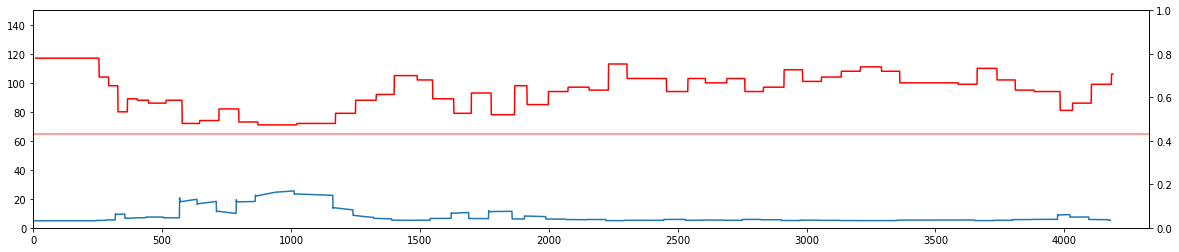

10/10 [==============================] - 0s 16ms/step
Print error: 5221	0.03246736330051027	


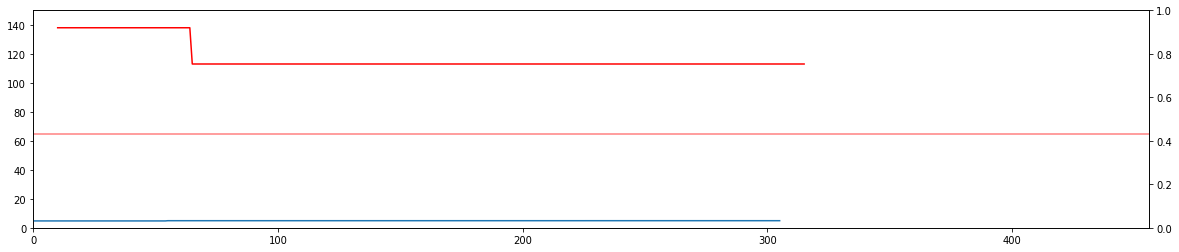

58/58 [==============================] - 1s 15ms/step
Print error: 5229	0.18760772431823647	


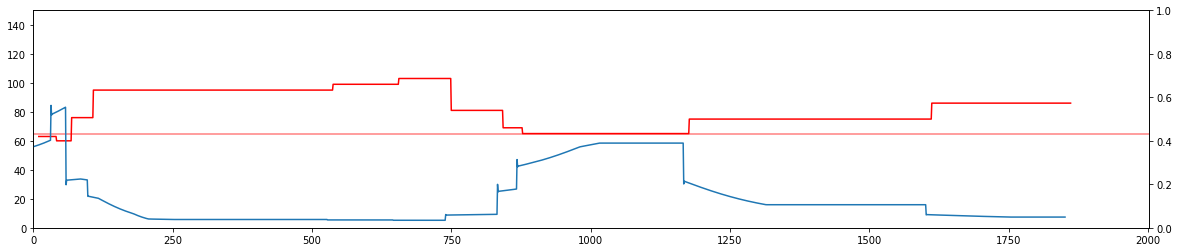

116/116 [==============================] - 2s 16ms/step
Print error: 5249	0.4134120690849378	


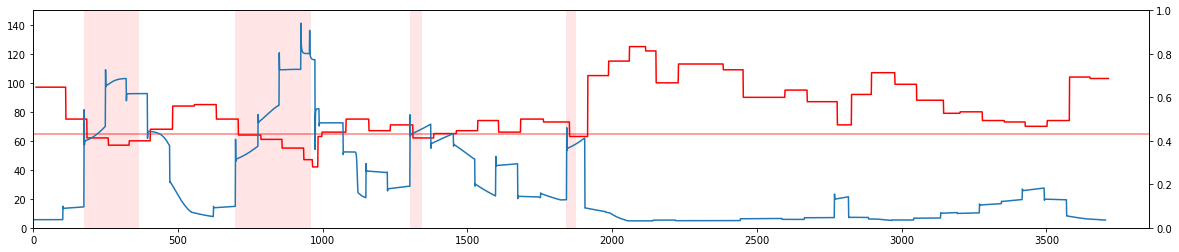

153/153 [==============================] - 2s 13ms/step
Print error: 5252	0.31802421901427963	


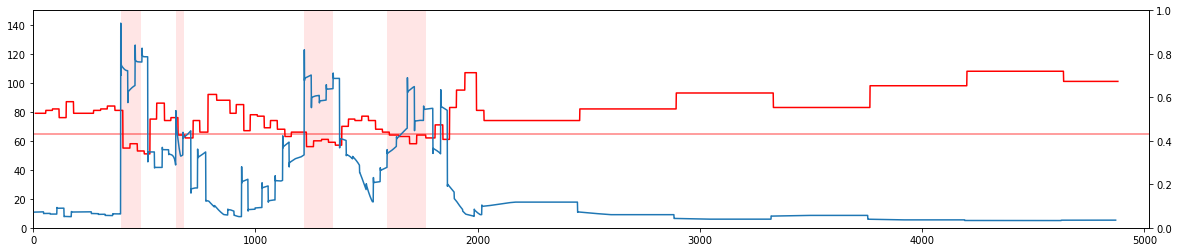

145/145 [==============================] - 2s 14ms/step
Print error: 5263	0.17807888345874004	


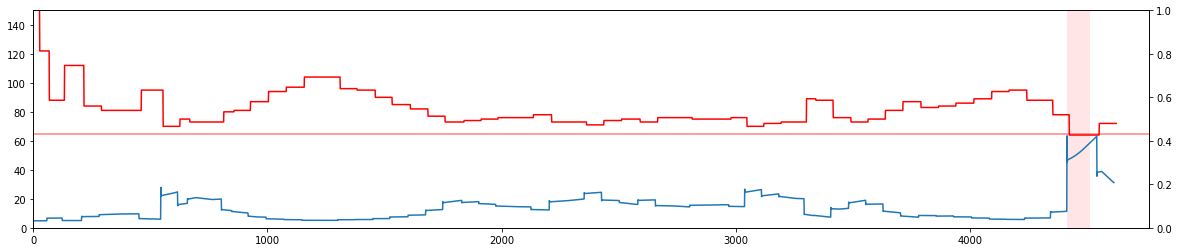

99/99 [==============================] - 2s 15ms/step
Print error: 5279	0.3374676786063604	


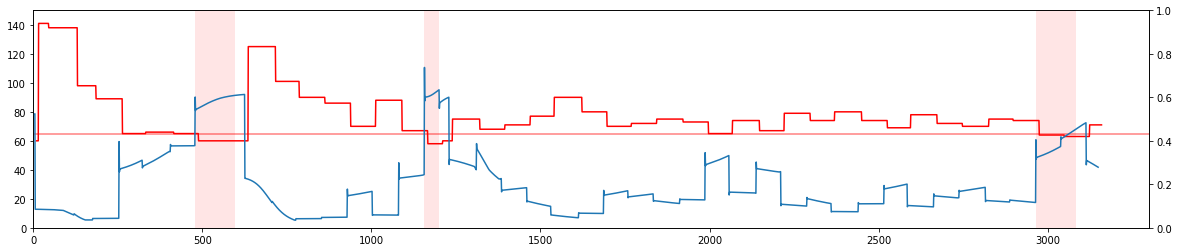

128/128 [==============================] - 2s 15ms/step
Print error: 5284	0.37982873605284095	


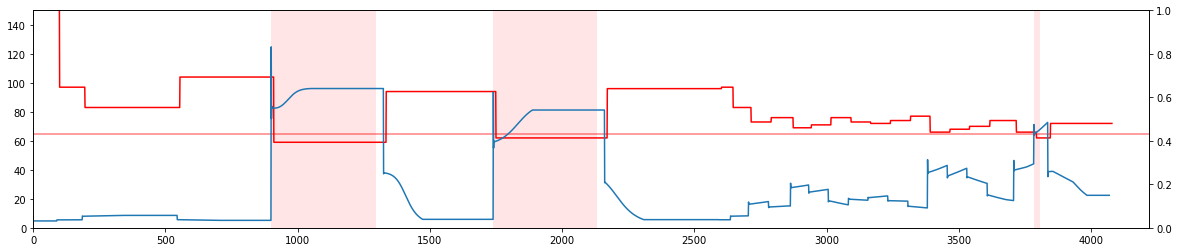

39/39 [==============================] - 1s 15ms/step
Print error: 5293	0.49983433124603316	


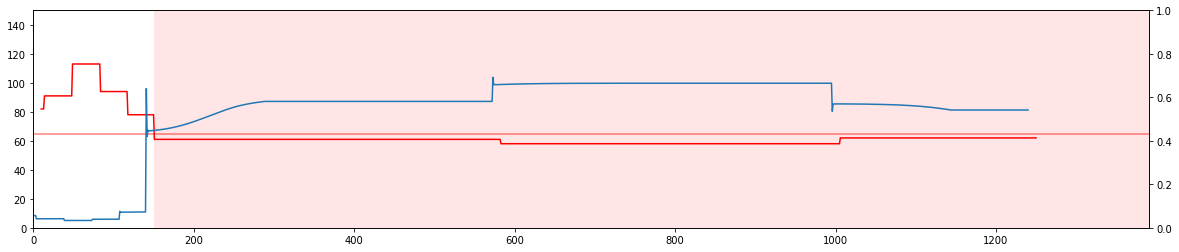

47/47 [==============================] - 1s 14ms/step
Print error: 5295	0.05482052054331079	


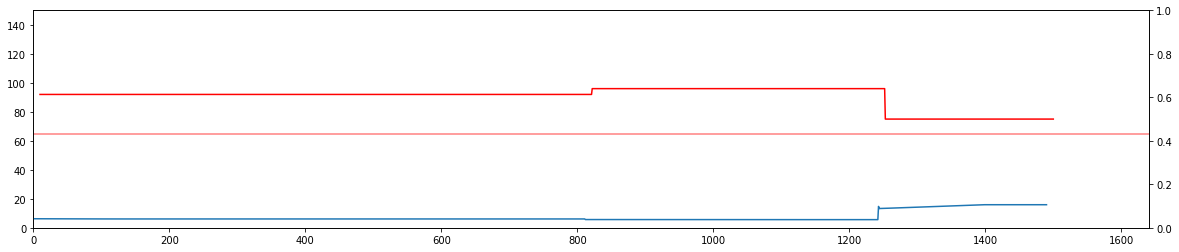

41/41 [==============================] - 1s 19ms/step
Print error: 5297	0.21467673138648496	


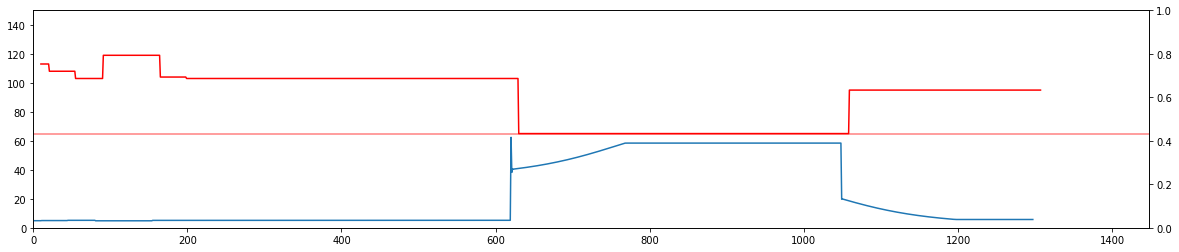

193/193 [==============================] - 3s 14ms/step
Print error: 5318	0.34760334383842667	


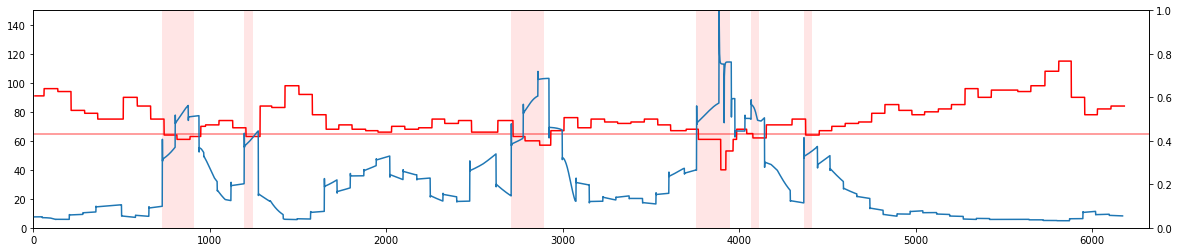

245/245 [==============================] - 4s 15ms/step
Print error: 5335	0.19439182723824716	


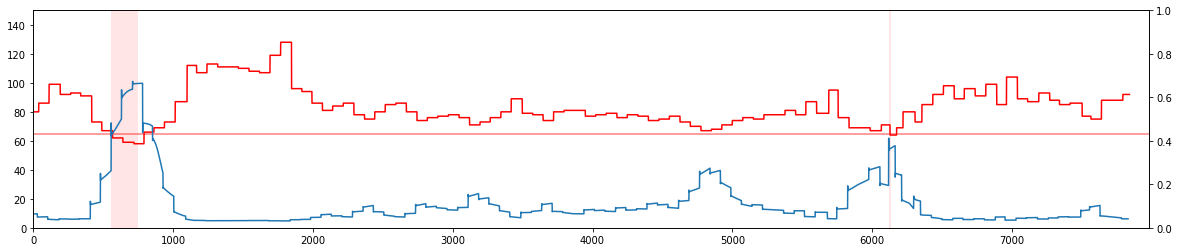

97/97 [==============================] - 2s 16ms/step
Print error: 5345	0.26550611472137714	


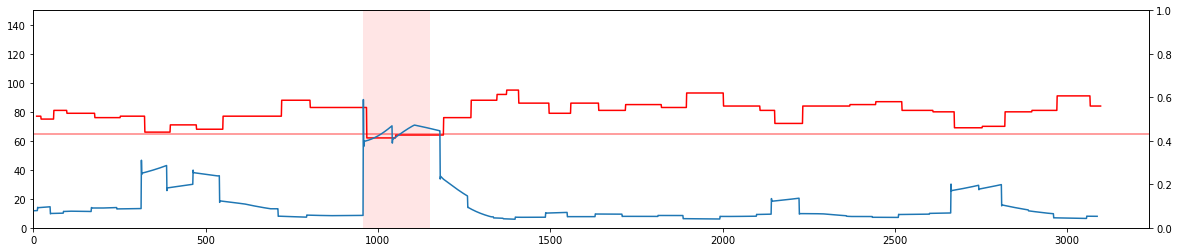

186/186 [==============================] - 3s 16ms/step
Print error: 5361	0.22618687667244294	


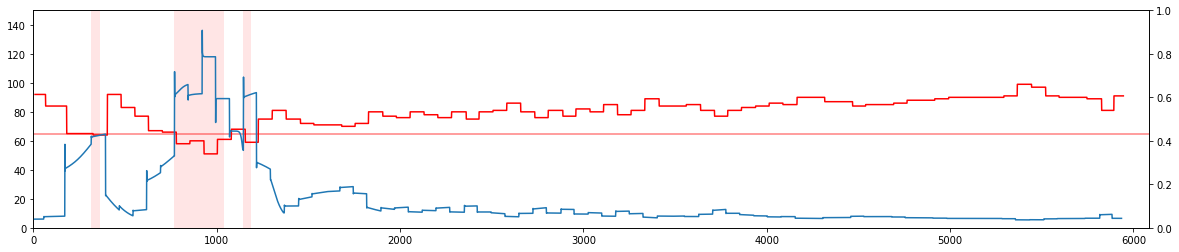

112/112 [==============================] - 1s 13ms/step
Print error: 5378	0.04329508168792519	


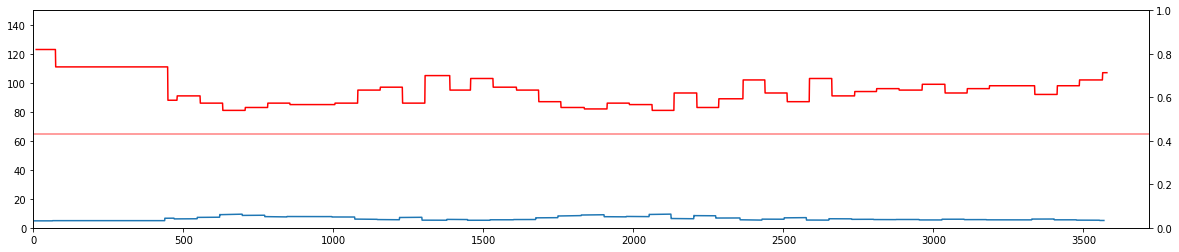

99/99 [==============================] - 1s 13ms/step
Print error: 5387	0.30298285592633634	


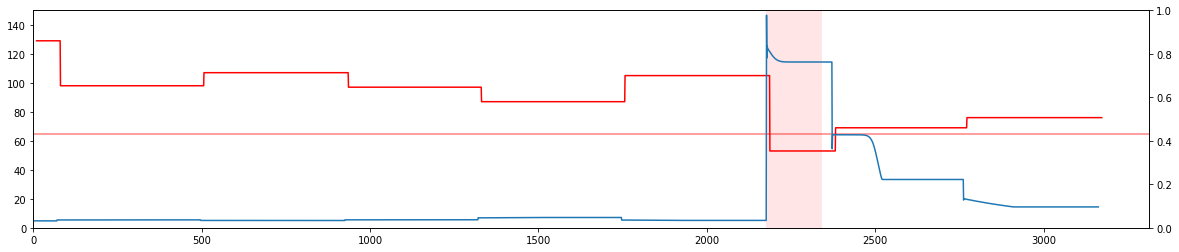

29/29 [==============================] - 0s 12ms/step
Print error: 5395	0.05407044646882171	


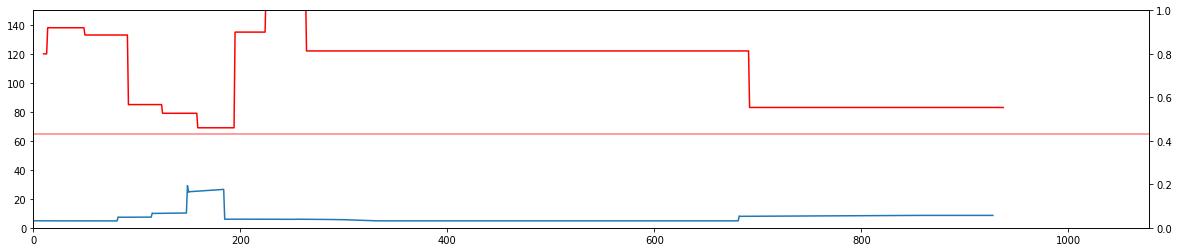

261/261 [==============================] - 4s 14ms/step
Print error: 5400	0.23892724692747125	


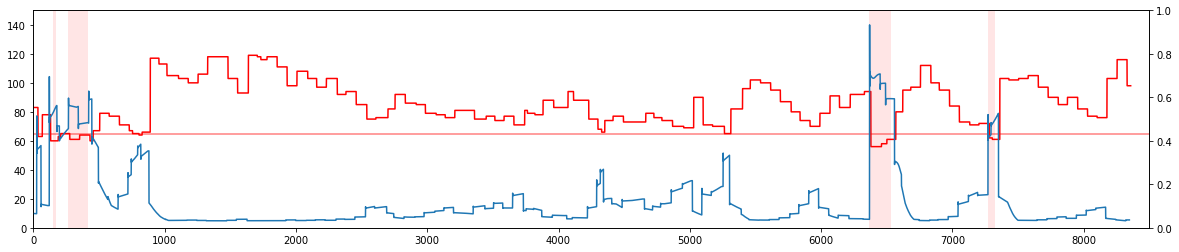

75/75 [==============================] - 1s 16ms/step
Print error: 5402	0.05082007904350967	


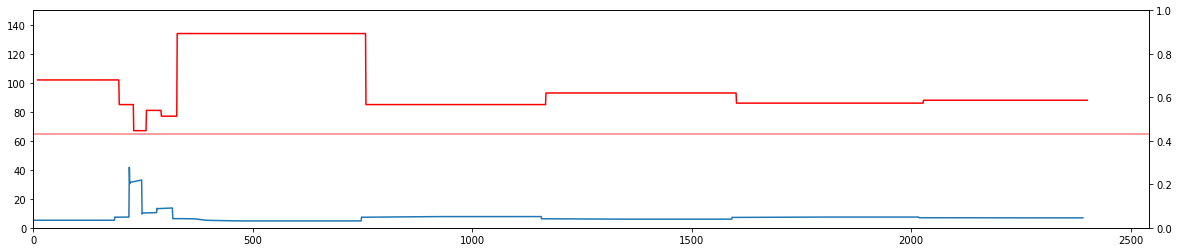

60/60 [==============================] - 1s 17ms/step
Print error: 5423	0.07008360985860312	


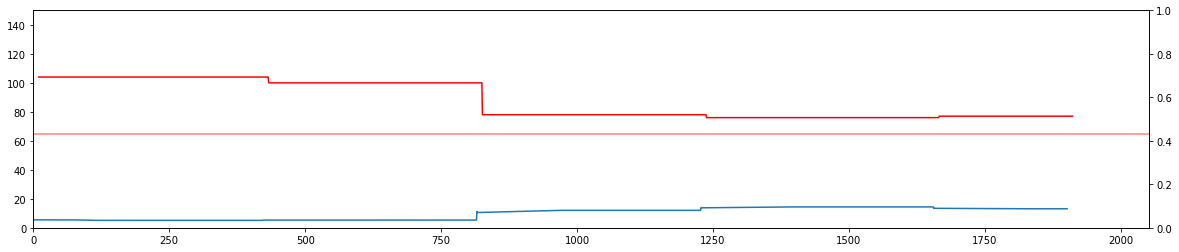

186/186 [==============================] - 3s 15ms/step
Print error: 5465	0.23749493794316914	


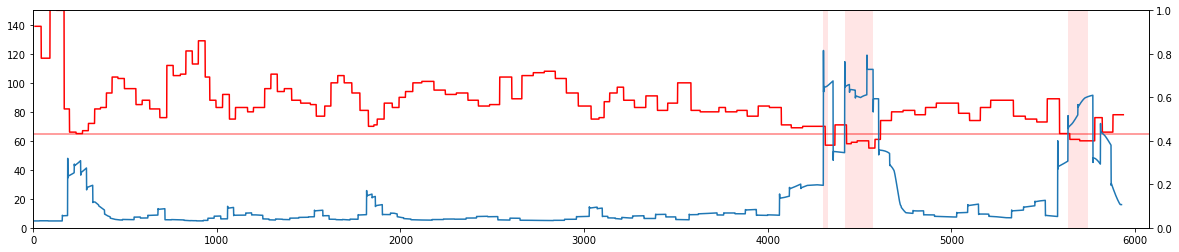

149/149 [==============================] - 2s 16ms/step
Print error: 5469	0.05512644452450865	


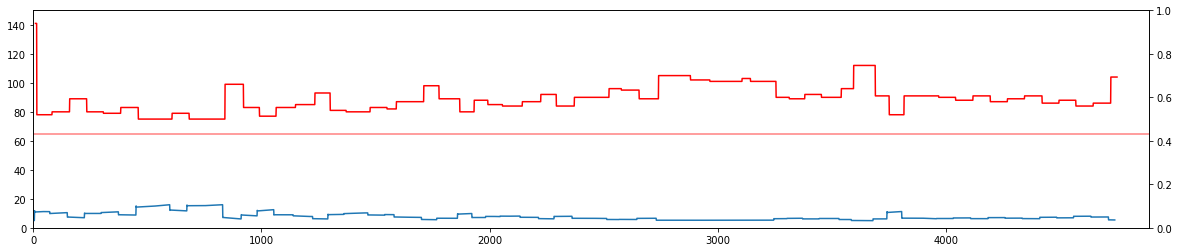

185/185 [==============================] - 3s 15ms/step
Print error: 5494	0.39677634552424695	


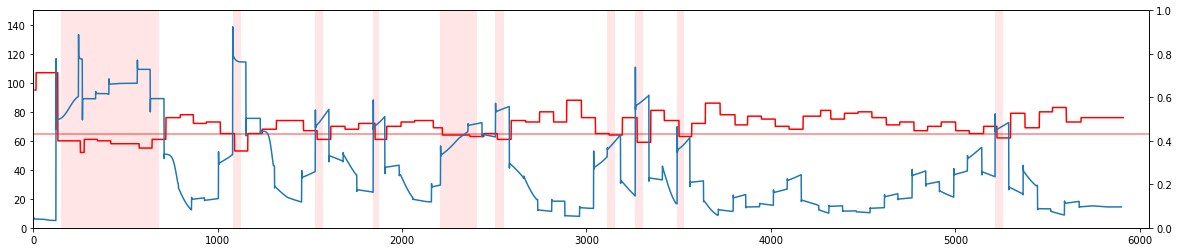

148/148 [==============================] - 2s 12ms/step
Print error: 5506	0.211240074584782	


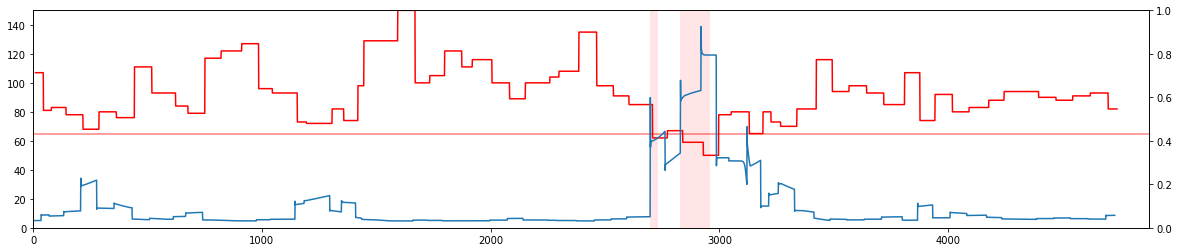

62/62 [==============================] - 1s 17ms/step
Print error: 5509	0.048157129902570824	


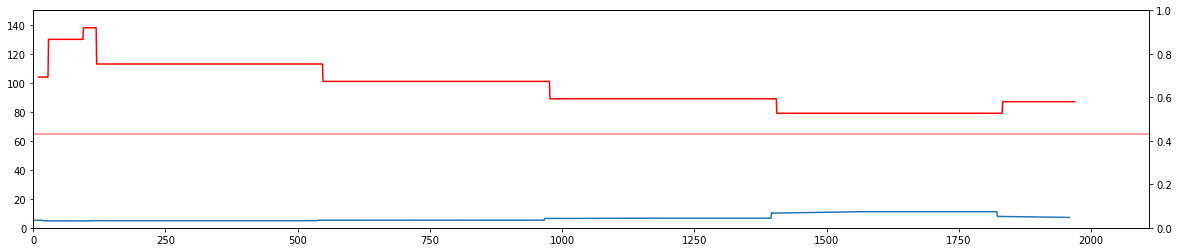

146/146 [==============================] - 2s 15ms/step
Print error: 5516	0.10488527550815534	


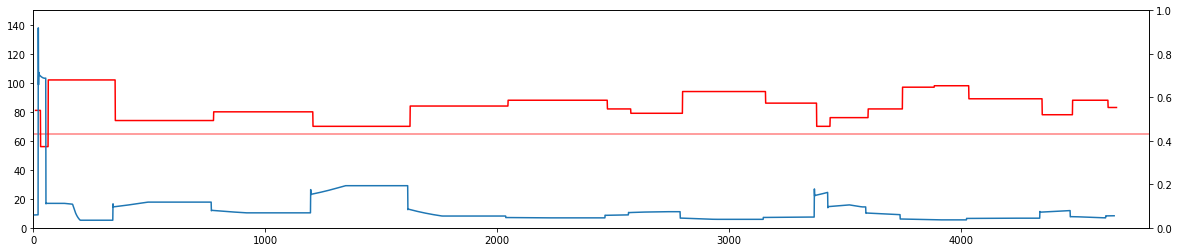

115/115 [==============================] - 2s 15ms/step
Print error: 5523	0.09853532430069263	


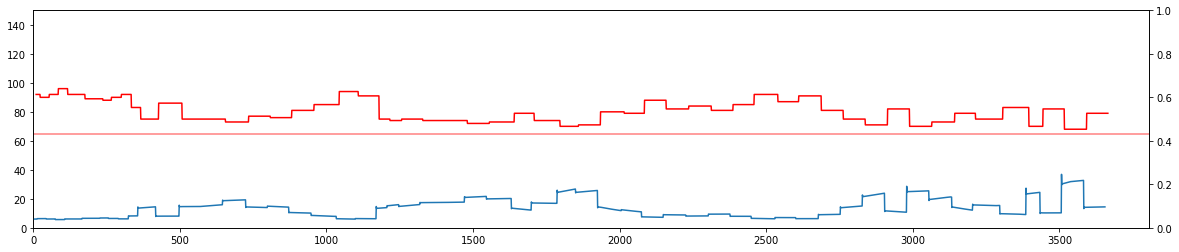

141/141 [==============================] - 2s 15ms/step
Print error: 5540	0.1337883246185671	


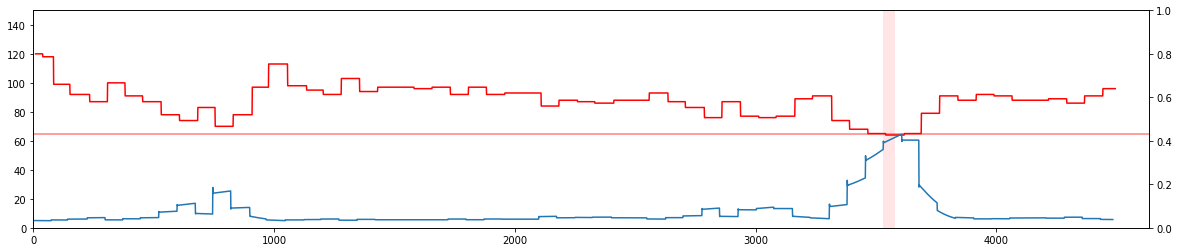

123/123 [==============================] - 2s 15ms/step
Print error: 5555	0.3381552789848846	


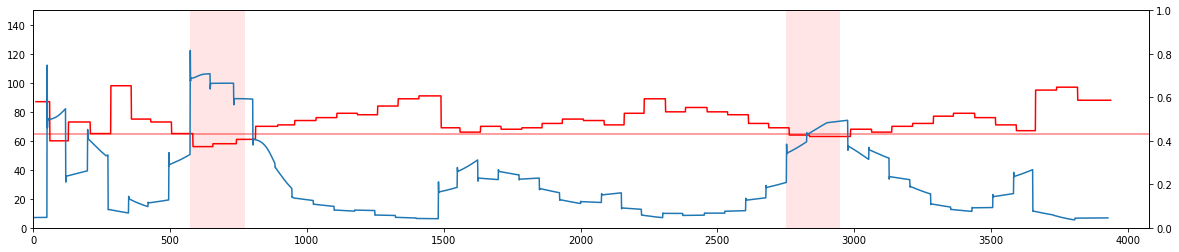

51/51 [==============================] - 1s 14ms/step
Print error: 5566	0.03283562356334535	


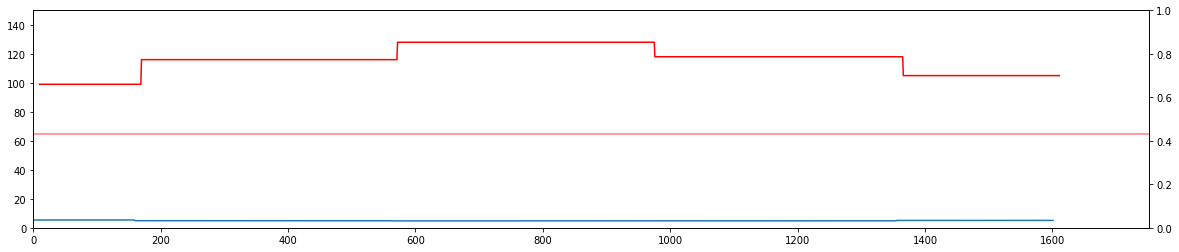

10/10 [==============================] - 0s 20ms/step
Print error: 5568	0.19322381903316724	


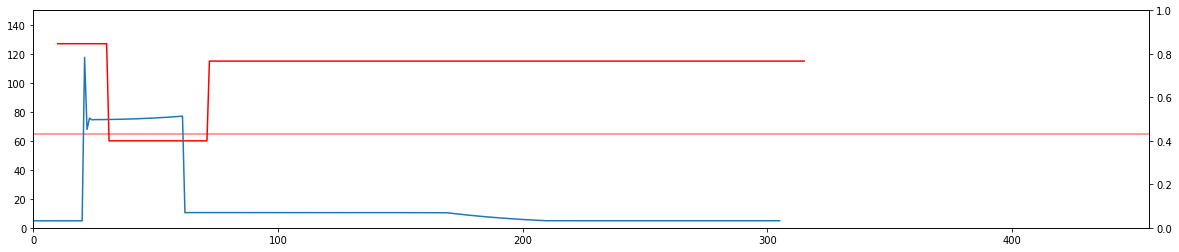

109/109 [==============================] - 2s 16ms/step
Print error: 5570	0.34577727734834407	


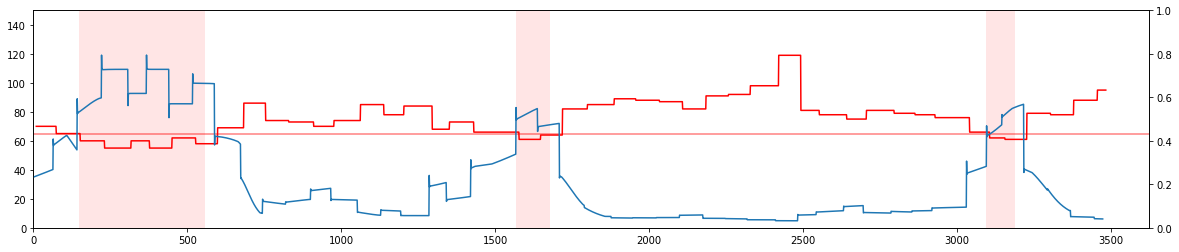

83/83 [==============================] - 1s 14ms/step
Print error: 5582	0.21399519412156934	


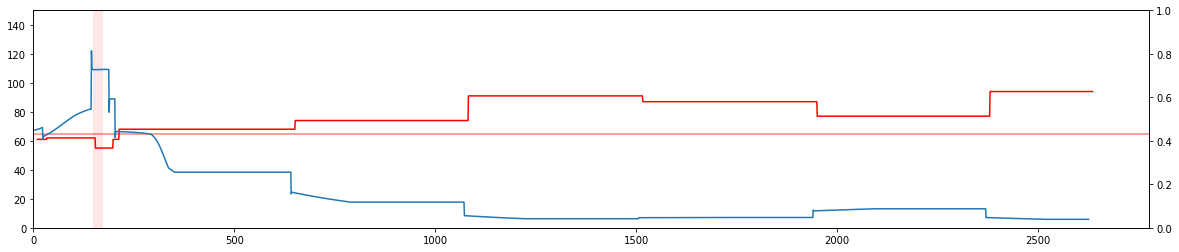

235/235 [==============================] - 3s 15ms/step
Print error: 5596	0.048032421267945574	


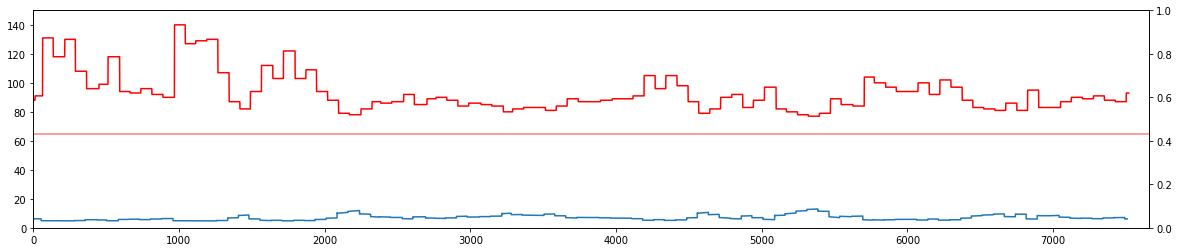

55/55 [==============================] - 1s 17ms/step
Print error: 5600	0.03568957043849094	


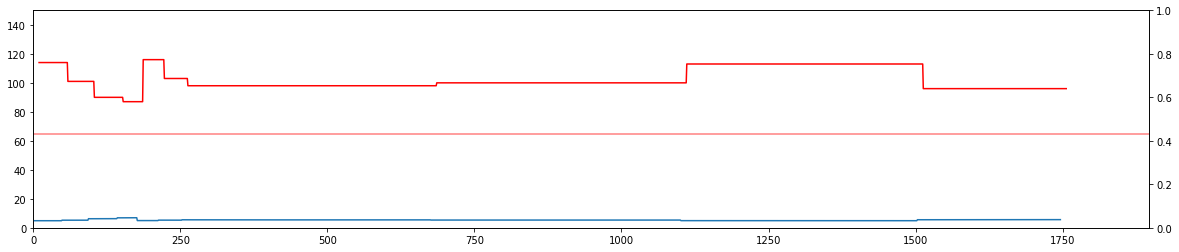

62/62 [==============================] - 1s 17ms/step
Print error: 5601	0.18018506447465582	


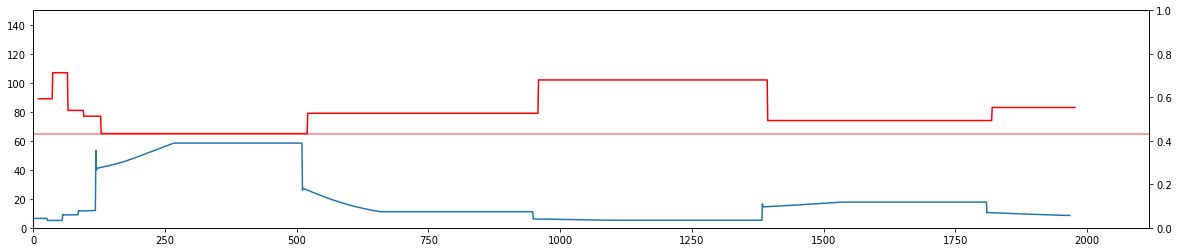

48/48 [==============================] - 1s 16ms/step
Print error: 5627	0.12648739116670427	


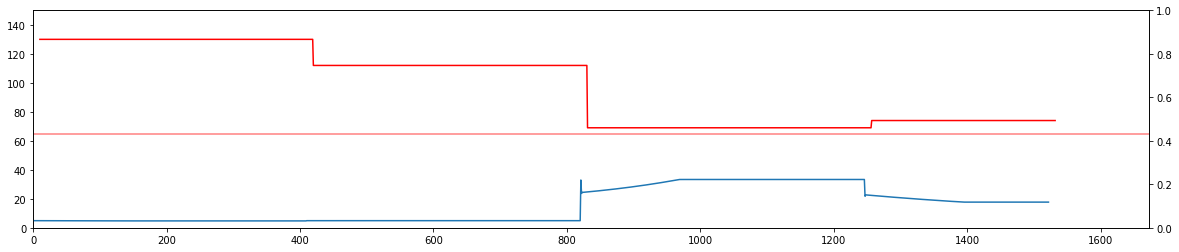

113/113 [==============================] - 2s 15ms/step
Print error: 5631	0.23111729777248738	


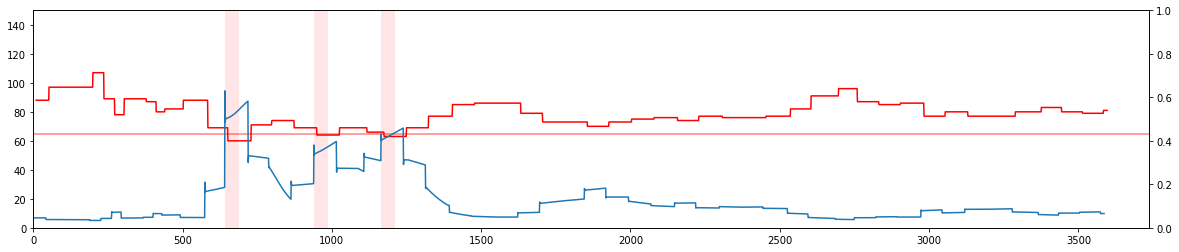

162/162 [==============================] - 2s 14ms/step
Print error: 5639	0.25535633051778295	


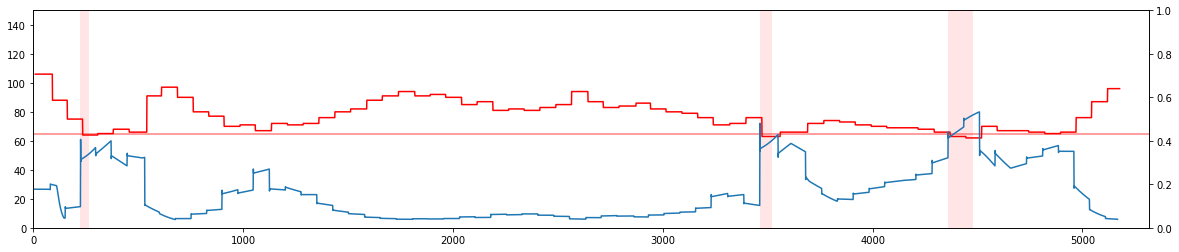

152/152 [==============================] - 2s 15ms/step
Print error: 5644	0.11421488093908476	


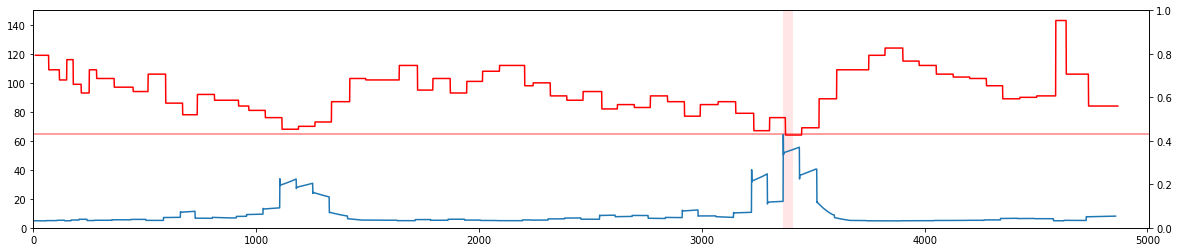

43/43 [==============================] - 1s 15ms/step
Print error: 5658	0.1421372901380206	


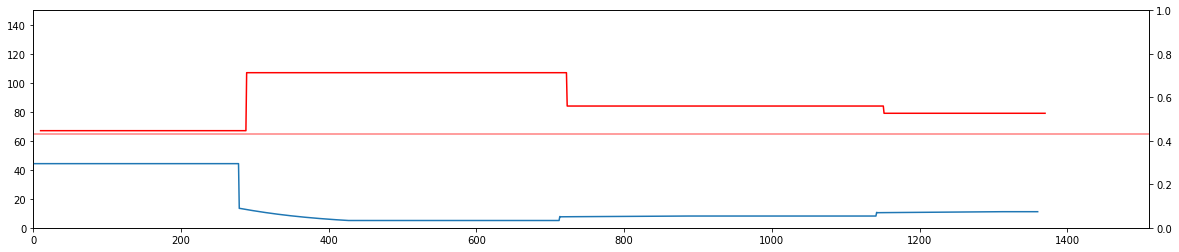

86/86 [==============================] - 1s 15ms/step
Print error: 5672	0.24360270940662904	


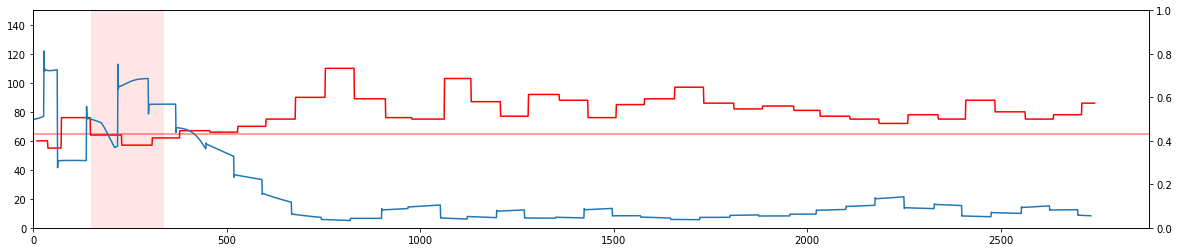

139/139 [==============================] - 2s 14ms/step
Print error: 5700	0.3492680167109166	


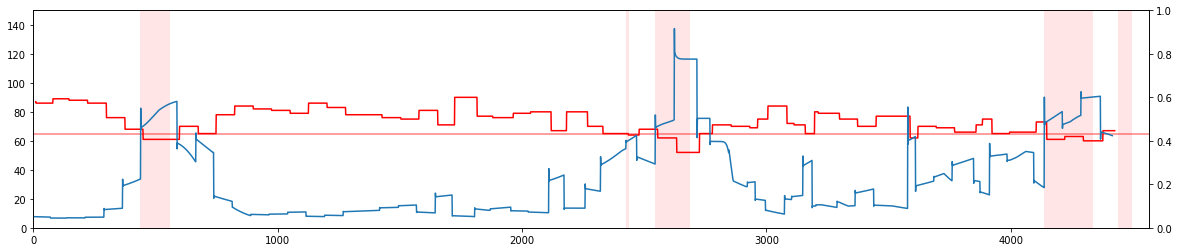

203/203 [==============================] - 3s 17ms/step
Print error: 5716	0.1064649616269495	


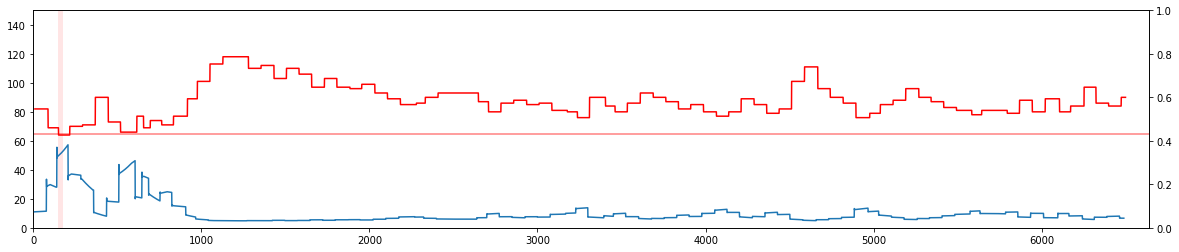

126/126 [==============================] - 2s 17ms/step
Print error: 5731	0.0851643691873203	


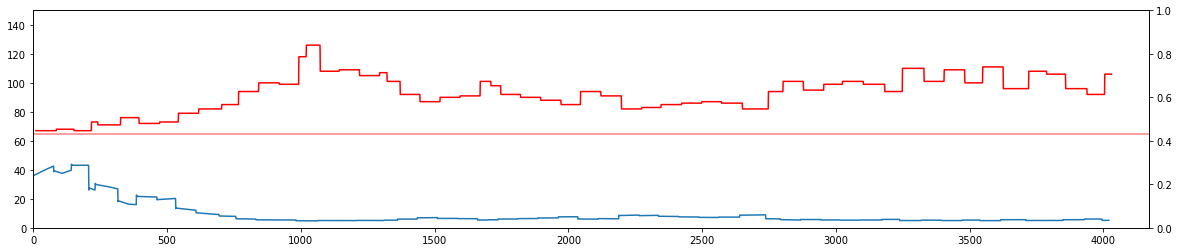

181/181 [==============================] - 3s 15ms/step
Print error: 5734	0.06682561888933534	


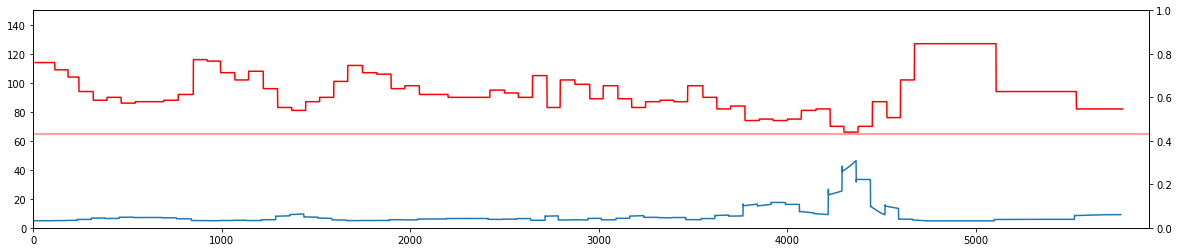

203/203 [==============================] - 3s 16ms/step
Print error: 5737	0.22979679588865876	


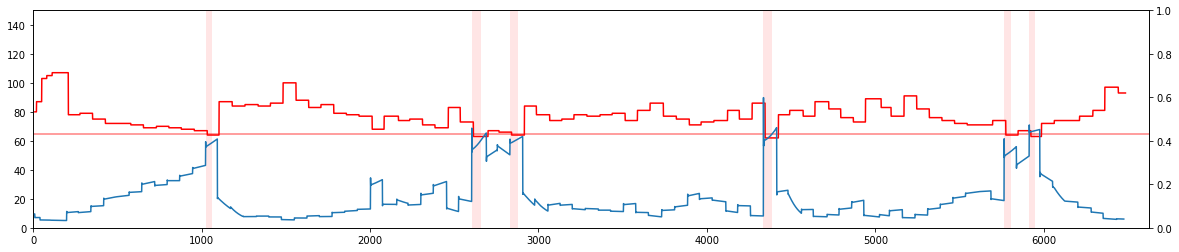

130/130 [==============================] - 2s 17ms/step
Print error: 5741	0.060158541716234616	


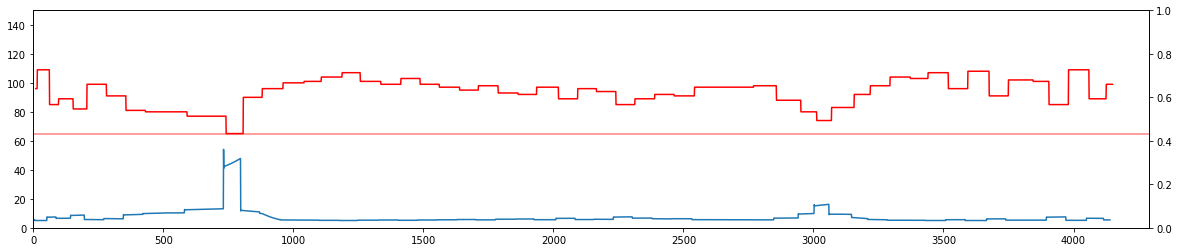

105/105 [==============================] - 2s 15ms/step
Print error: 5742	0.3462569654879589	


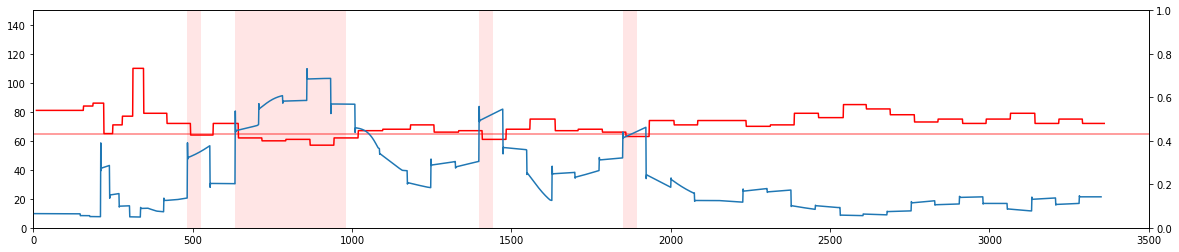

204/204 [==============================] - 3s 14ms/step
Print error: 5756	0.14347442017785547	


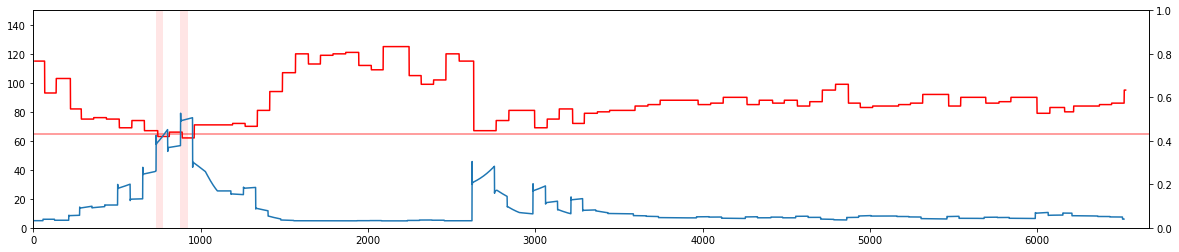

202/202 [==============================] - 3s 15ms/step
Print error: 5764	0.28538154167801505	


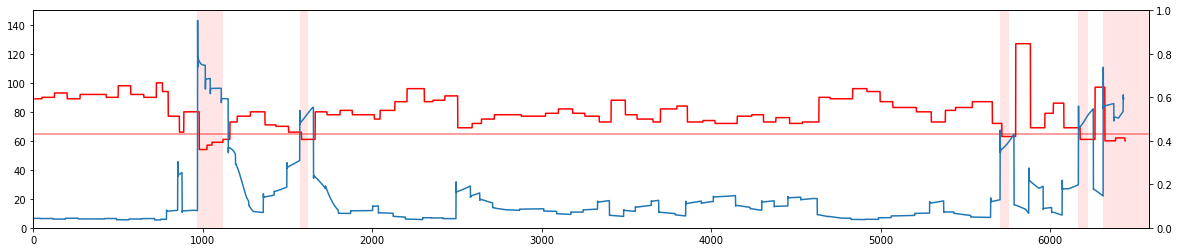

268/268 [==============================] - 4s 16ms/step
Print error: 5786	0.20116949542962254	


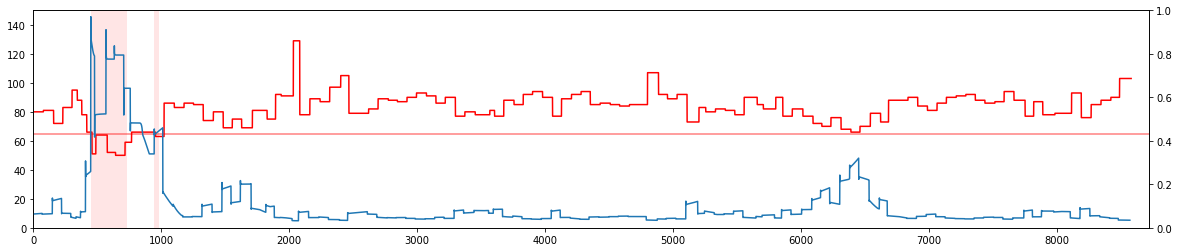

183/183 [==============================] - 3s 16ms/step
Print error: 5798	0.33895672761239404	


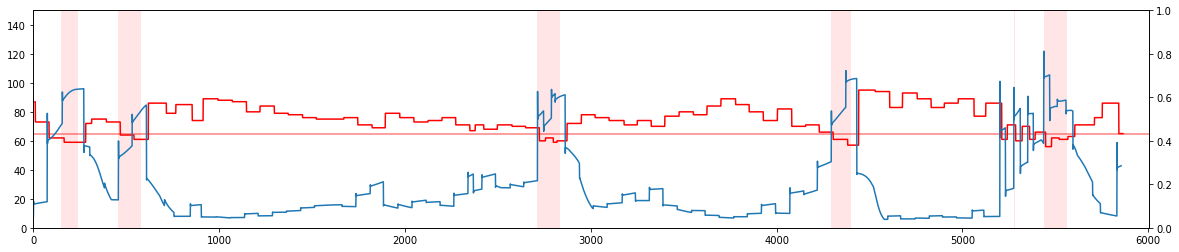

136/136 [==============================] - 2s 17ms/step
Print error: 5821	0.23943776739509326	


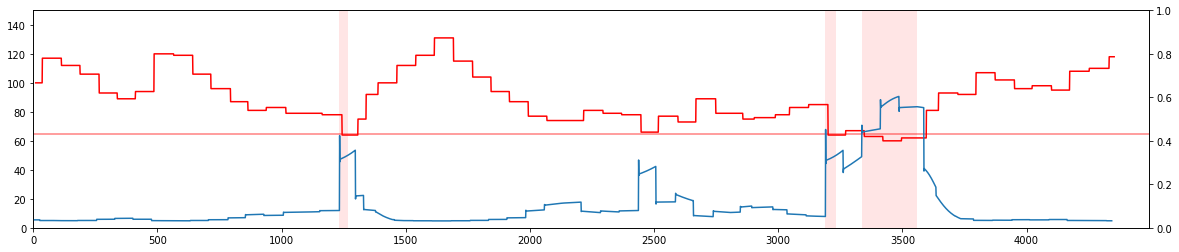

121/121 [==============================] - 2s 15ms/step
Print error: 5828	0.2333270406655038	


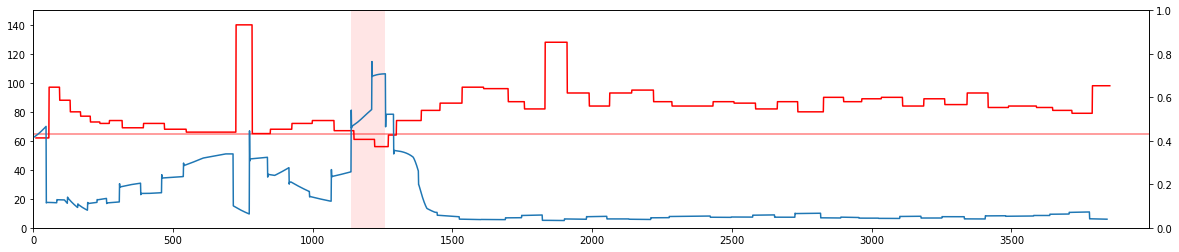

69/69 [==============================] - 1s 14ms/step
Print error: 5834	0.07458929682988352	


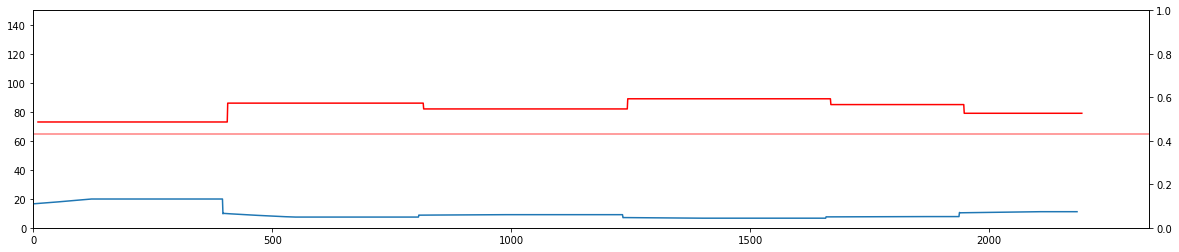

267/267 [==============================] - 4s 15ms/step
Print error: 5879	0.22326360651492436	


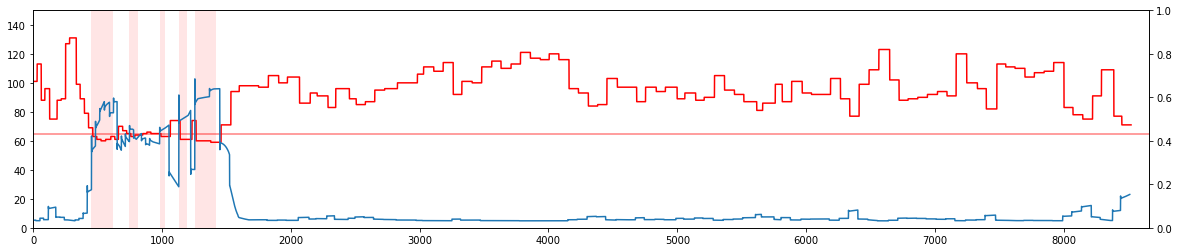

165/165 [==============================] - 3s 16ms/step
Print error: 5881	0.4489651503196583	


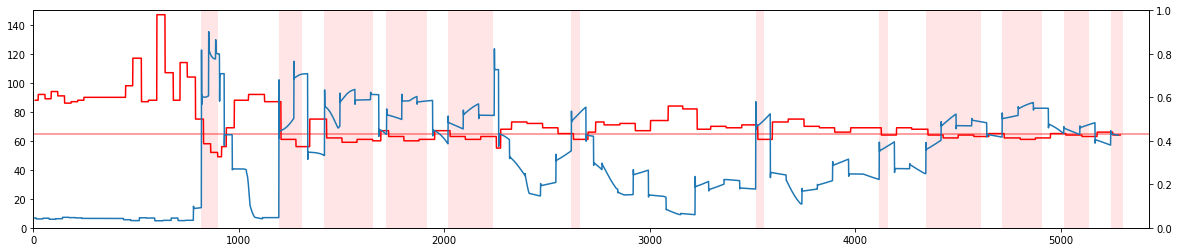

11/11 [==============================] - 0s 15ms/step
Print error: 5888	0.03309922229722617	


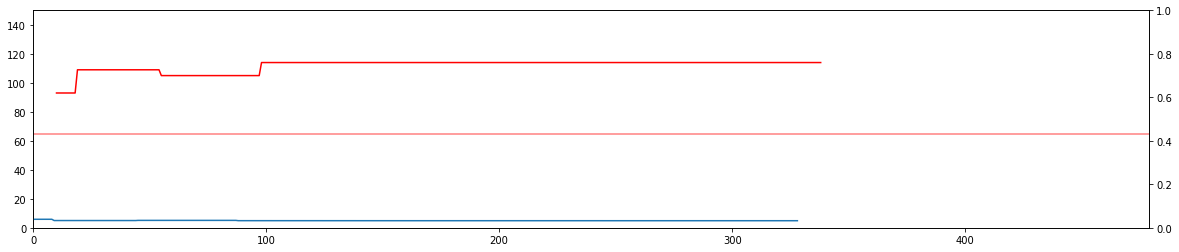

173/173 [==============================] - 3s 15ms/step
Print error: 5900	0.1871622639968649	


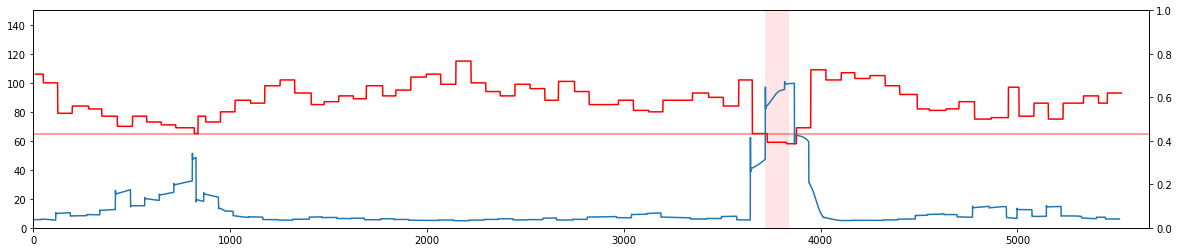

47/47 [==============================] - 1s 12ms/step
Print error: 5911	0.038197006981915096	


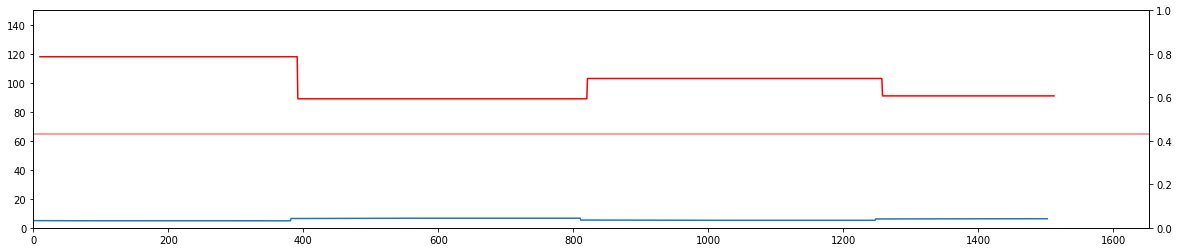

152/152 [==============================] - 2s 13ms/step
Print error: 5913	0.17439207470266258	


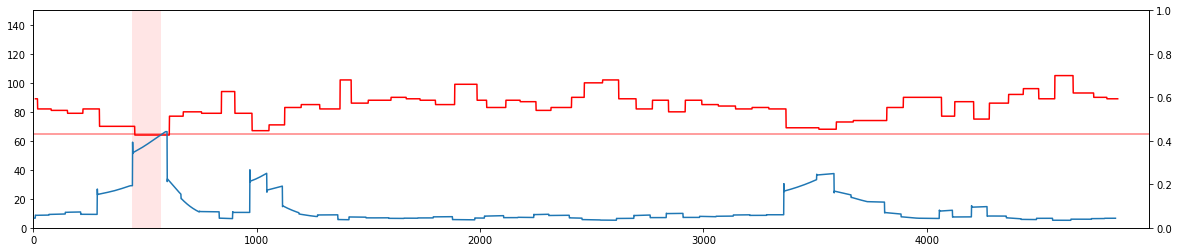

109/109 [==============================] - 2s 15ms/step
Print error: 5927	0.044263477392172956	


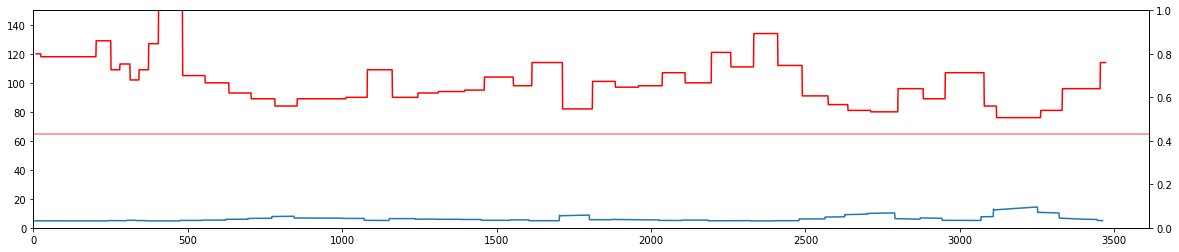

183/183 [==============================] - 3s 15ms/step
Print error: 5935	0.04647542352398127	


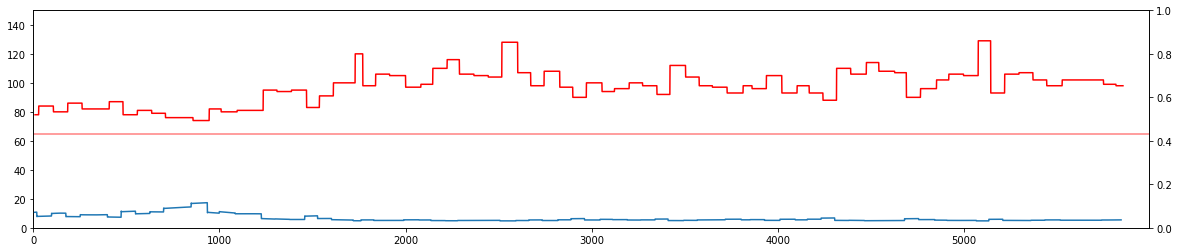

119/119 [==============================] - 2s 16ms/step
Print error: 5949	0.33073600126198166	


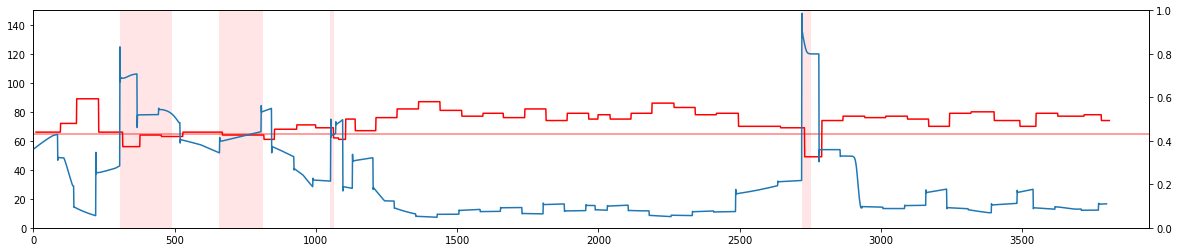

64/64 [==============================] - 1s 14ms/step
Print error: 5960	0.13151708120197267	


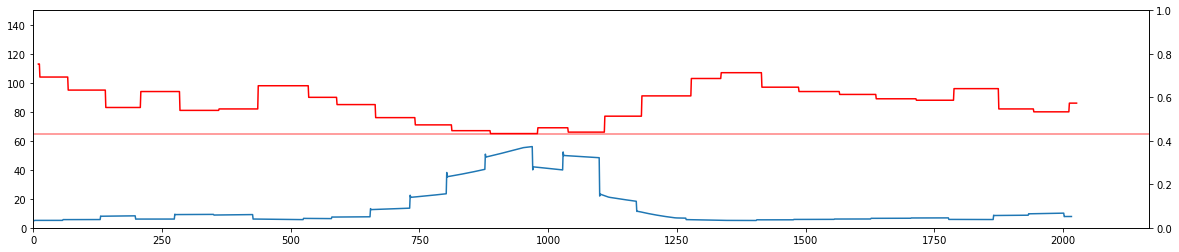

196/196 [==============================] - 3s 14ms/step
Print error: 5968	0.08255404534951595	


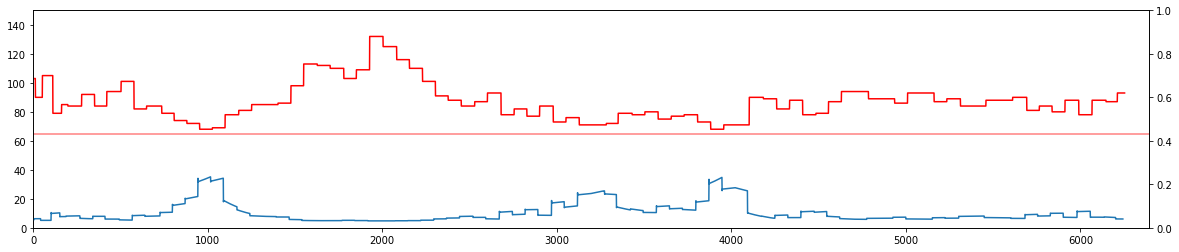

139/139 [==============================] - 2s 14ms/step
Print error: 5984	0.07497229884105235	


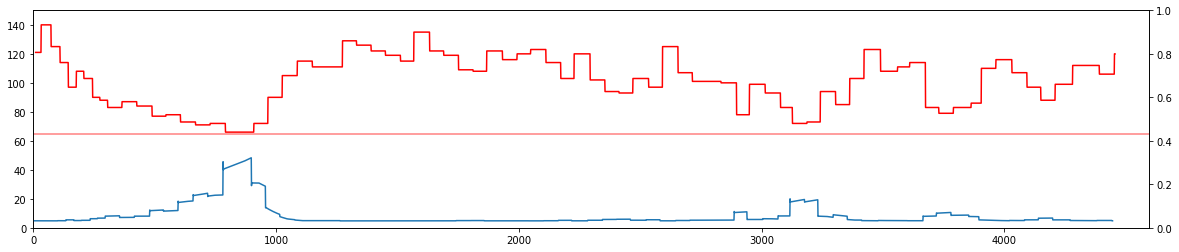

178/178 [==============================] - 3s 15ms/step
Print error: 6001	0.20846164248997445	


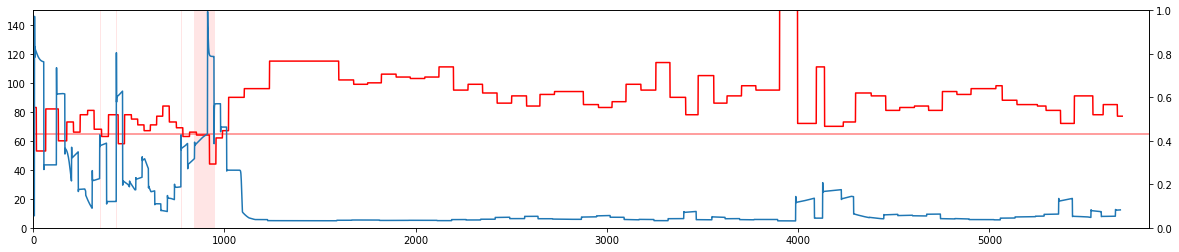

91/91 [==============================] - 1s 16ms/step
Print error: 6023	0.2692491049764947	


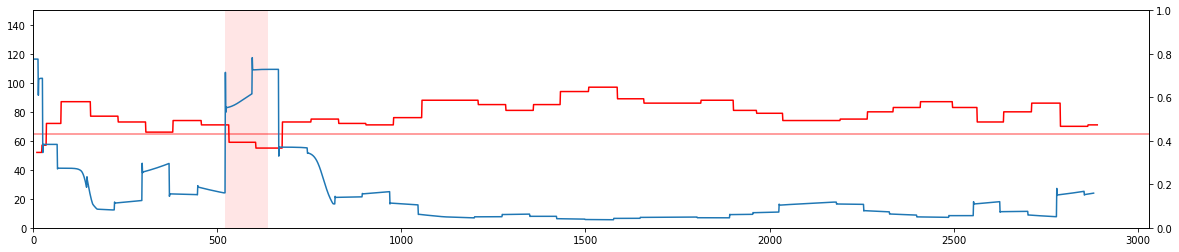

113/113 [==============================] - 2s 15ms/step
Print error: 6036	0.14774078694131015	


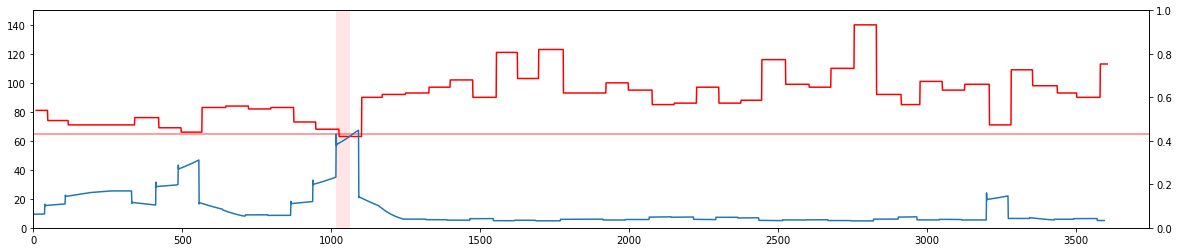

79/79 [==============================] - 1s 14ms/step
Print error: 6045	0.10055329895098142	


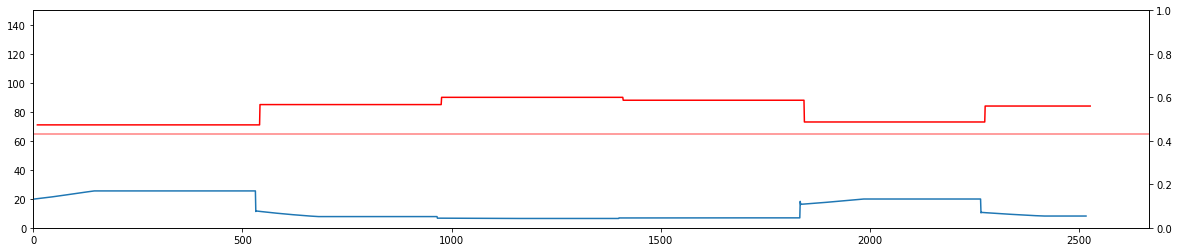

83/83 [==============================] - 2s 19ms/step
Print error: 6059	0.11710748722496596	


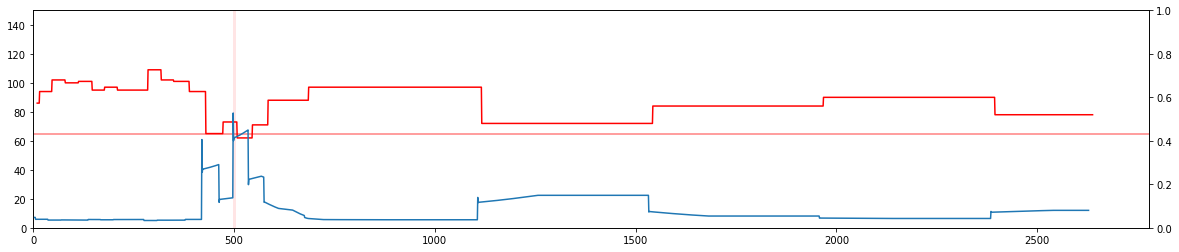

278/278 [==============================] - 4s 15ms/step
Print error: 6112	0.2533501330303613	


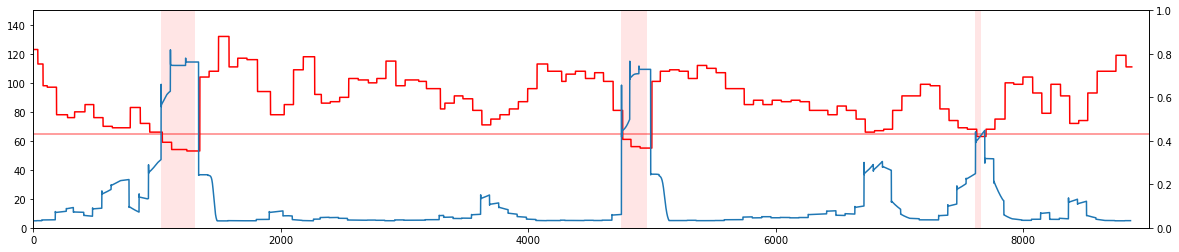

48/48 [==============================] - 1s 18ms/step
Print error: 6116	0.06958565271365756	


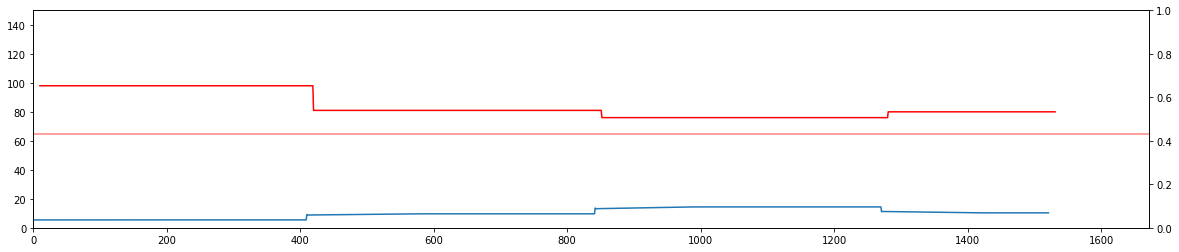

62/62 [==============================] - 1s 18ms/step
Print error: 6118	0.3490681961639836	


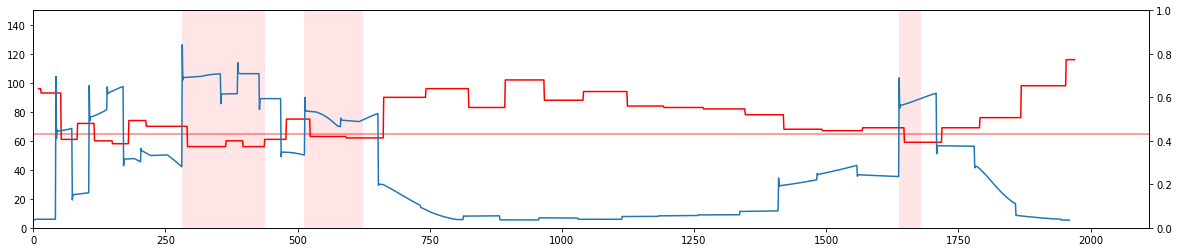

133/133 [==============================] - 2s 15ms/step
Print error: 6123	0.11474551748577455	


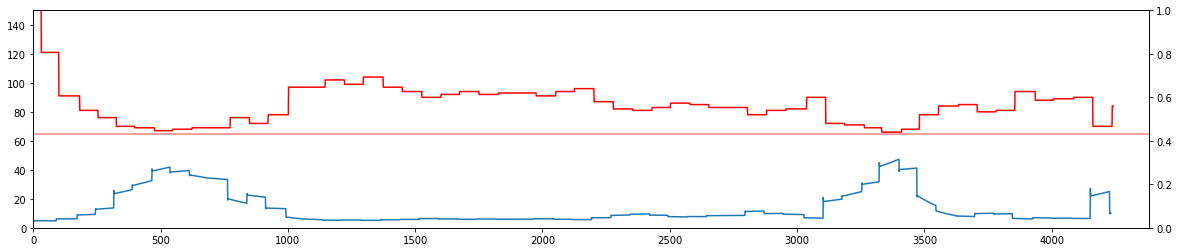

39/39 [==============================] - 1s 17ms/step
Print error: 6133	0.07320094854952401	


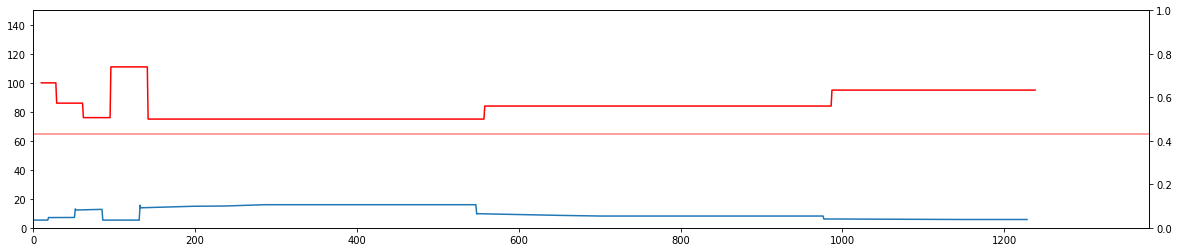

113/113 [==============================] - 2s 14ms/step
Print error: 6137	0.1420619845525719	


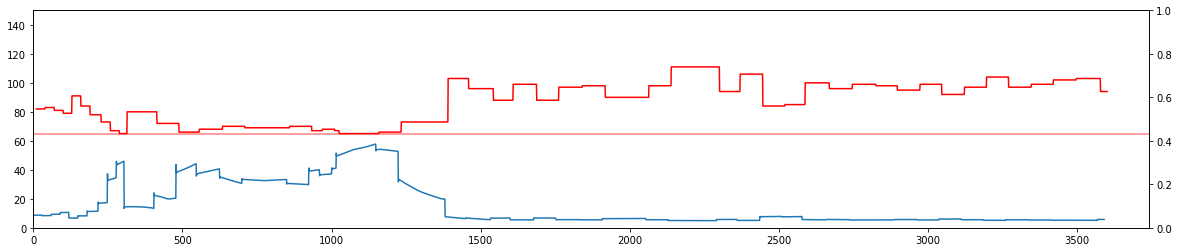

242/242 [==============================] - 4s 16ms/step
Print error: 6146	0.34882728644907807	


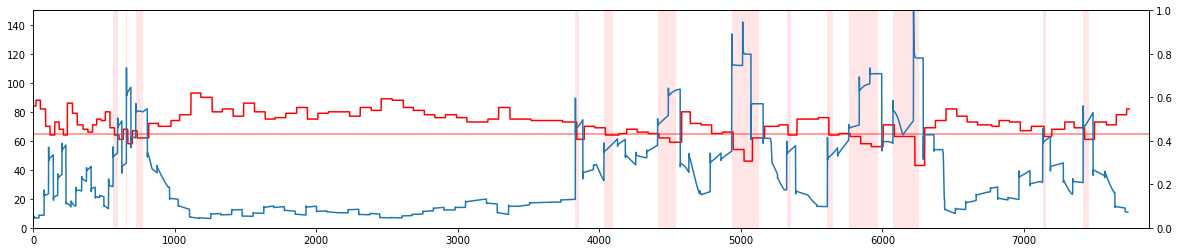

232/232 [==============================] - 3s 14ms/step
Print error: 6181	0.25551450943666865	


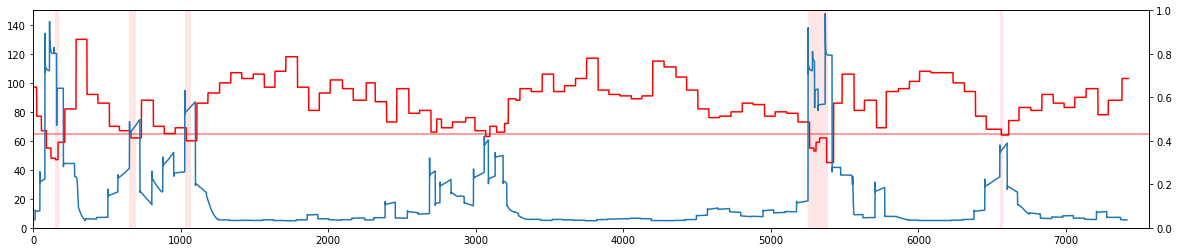

36/36 [==============================] - 1s 16ms/step
Print error: 6210	0.05491892349538752	


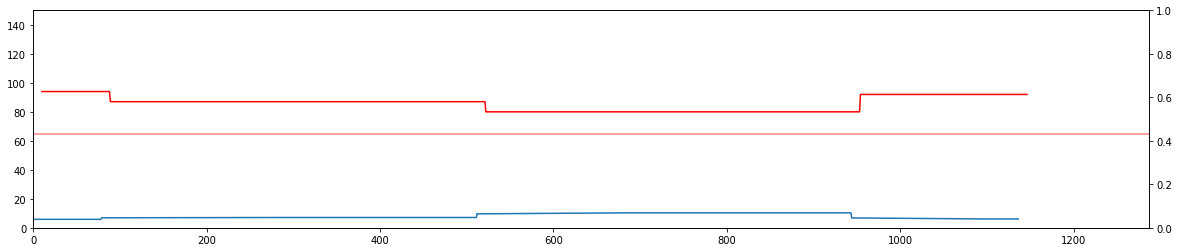

40/40 [==============================] - 1s 17ms/step
Print error: 6214	0.0895721331052419	


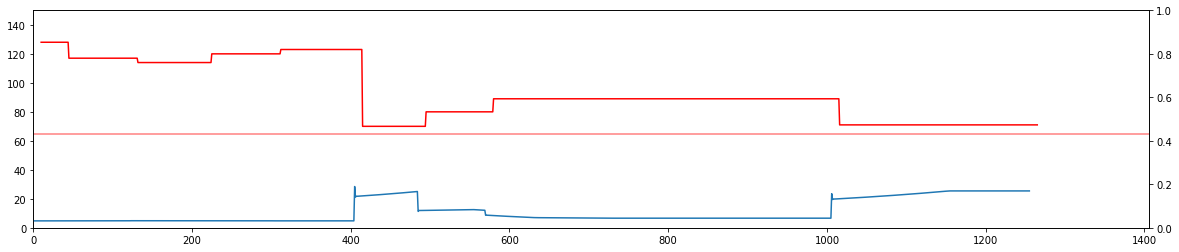

55/55 [==============================] - 1s 14ms/step
Print error: 6218	0.17031360284640712	


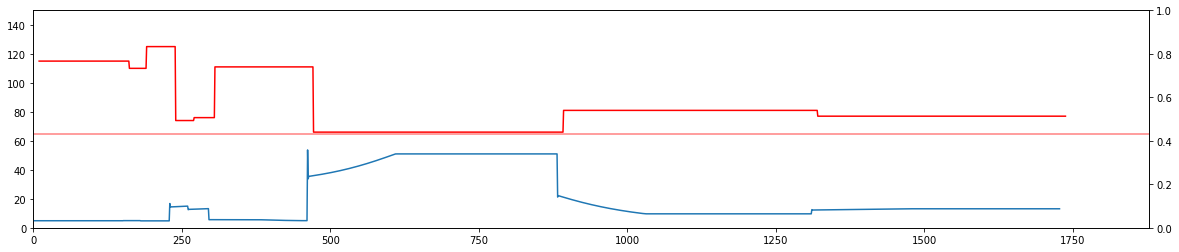

168/168 [==============================] - 2s 14ms/step
Print error: 6225	0.16535463015321678	


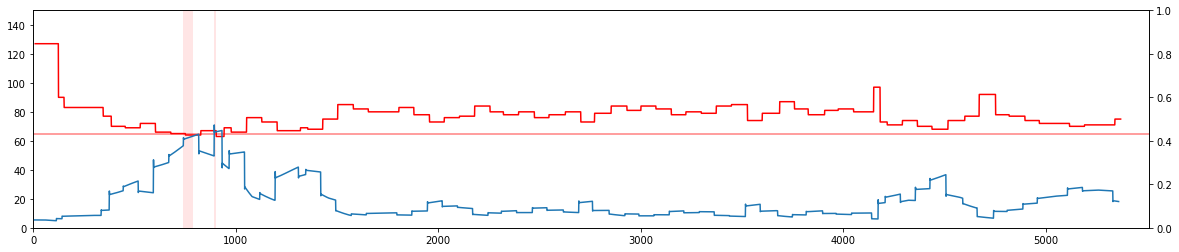

132/132 [==============================] - 2s 15ms/step
Print error: 6226	0.3947001747095684	


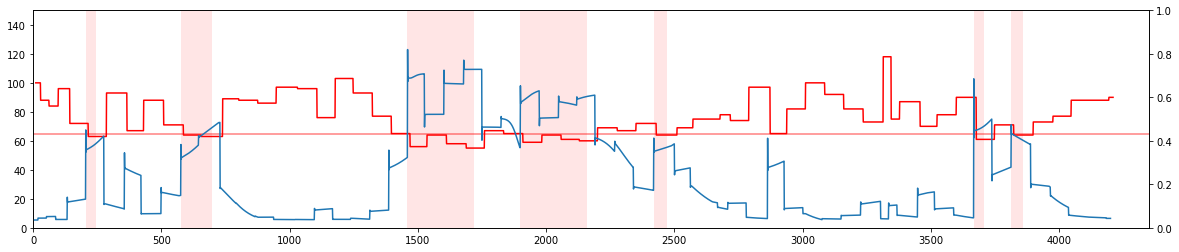

152/152 [==============================] - 3s 17ms/step
Print error: 6231	0.0910868118696341	


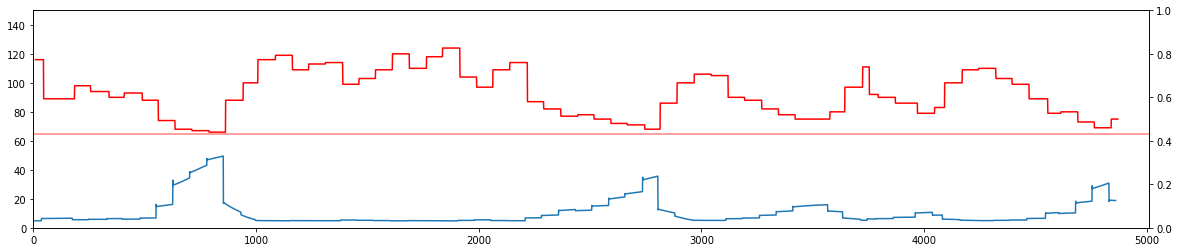

159/159 [==============================] - 3s 16ms/step
Print error: 6232	0.16929058668836003	


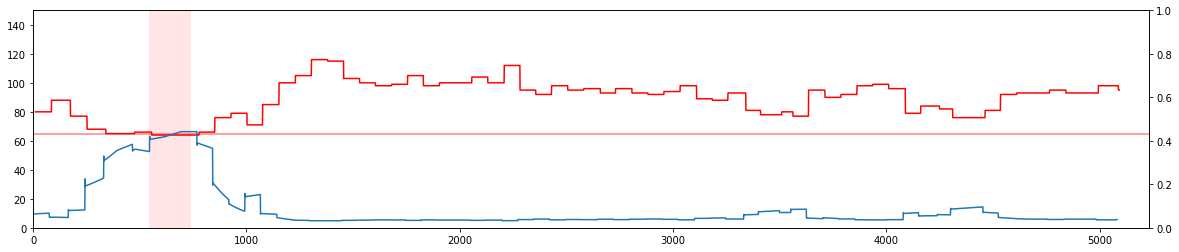

141/141 [==============================] - 2s 14ms/step
Print error: 6241	0.13002514748393493	


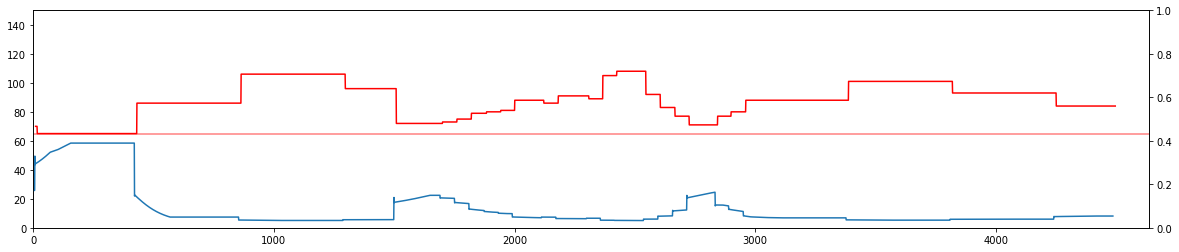

239/239 [==============================] - 4s 15ms/step
Print error: 6253	0.049683174861243115	


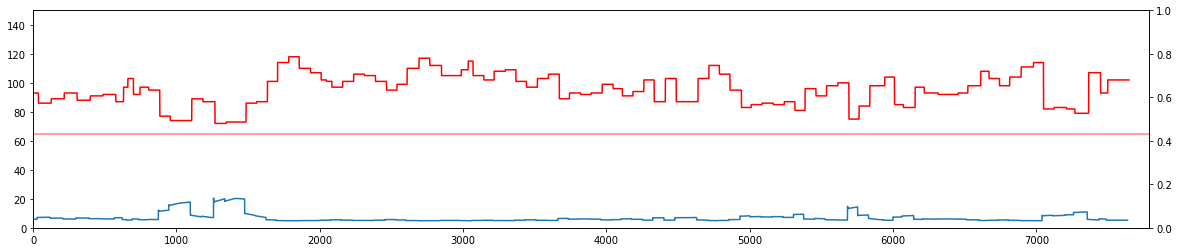

99/99 [==============================] - 2s 16ms/step
Print error: 6263	0.07976316232924145	


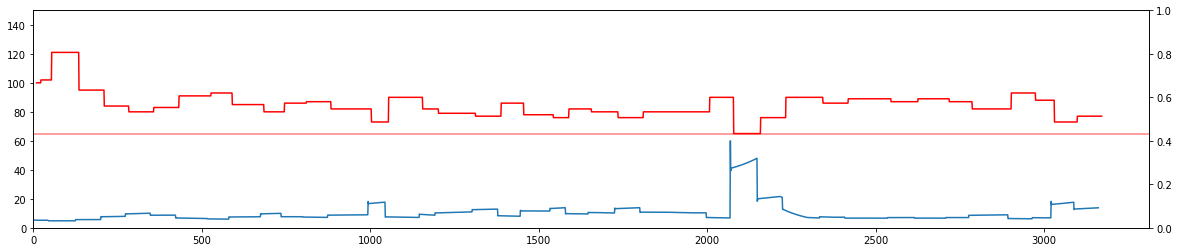

65/65 [==============================] - 1s 16ms/step
Print error: 6265	0.2196362542958186	


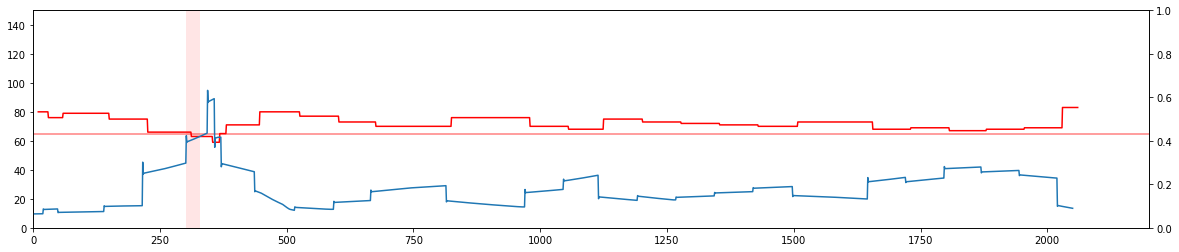

190/190 [==============================] - 3s 16ms/step
Print error: 6272	0.2341395705654062	


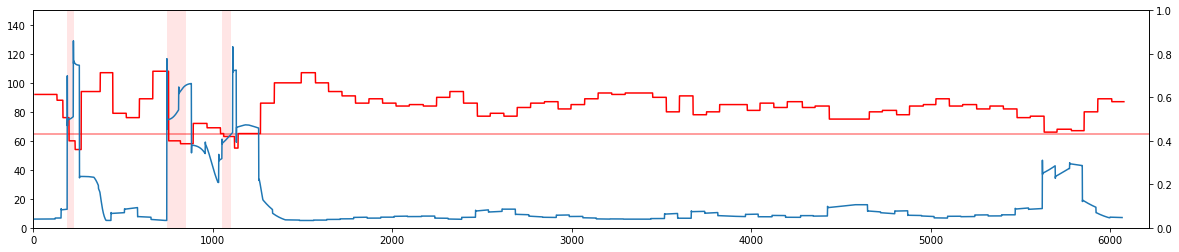

219/219 [==============================] - 3s 15ms/step
Print error: 6294	0.1445085146781186	


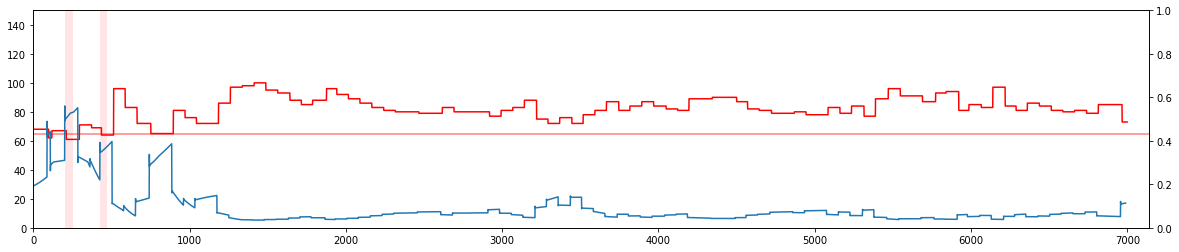

7/7 [==============================] - 0s 15ms/step
Print error: 6316	0.05633934230722794	


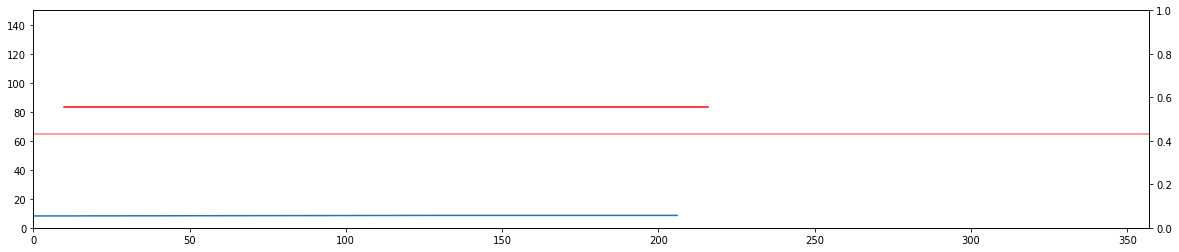

47/47 [==============================] - 1s 19ms/step
Print error: 6317	0.12241440532343445	


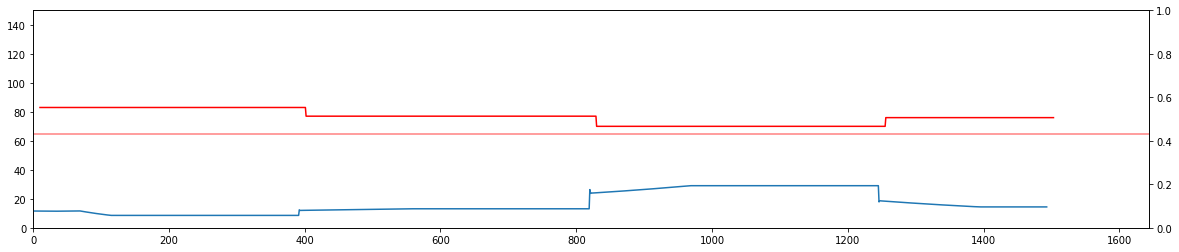

112/112 [==============================] - 2s 16ms/step
Print error: 6321	0.1766794146768242	


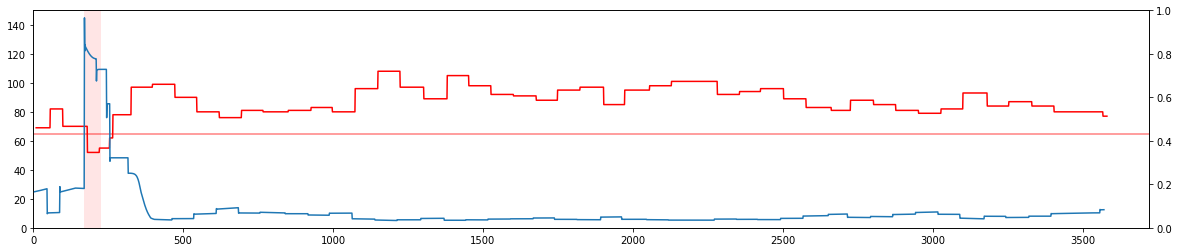

124/124 [==============================] - 2s 16ms/step
Print error: 6325	0.17642254937407673	


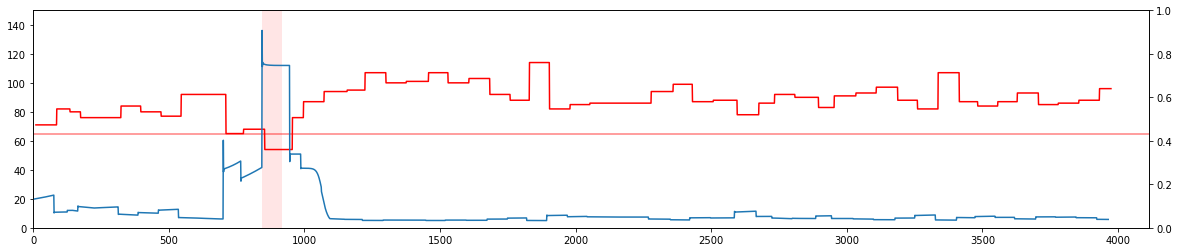

118/118 [==============================] - 2s 14ms/step
Print error: 6340	0.24673820308991162	


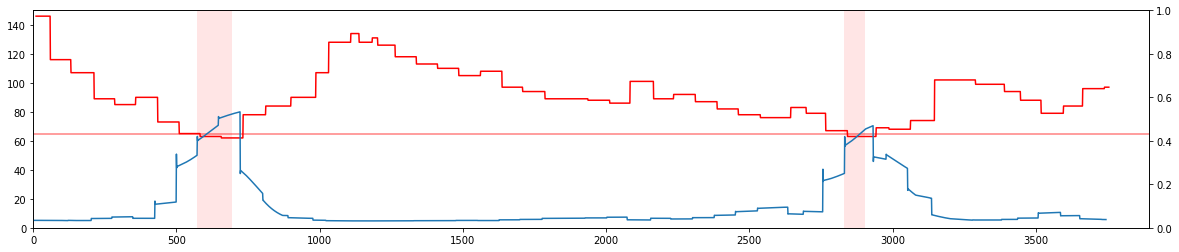

104/104 [==============================] - 1s 14ms/step
Print error: 6352	0.3772486975706153	


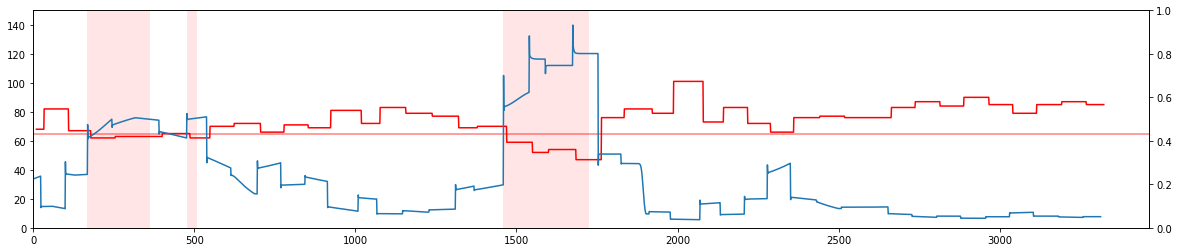

326/326 [==============================] - 5s 15ms/step
Print error: 6356	0.21266236448501702	


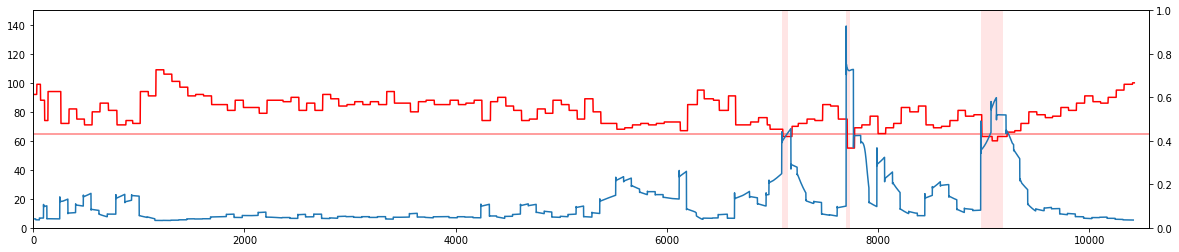

270/270 [==============================] - 3s 12ms/step
Print error: 6358	0.4406446452529765	


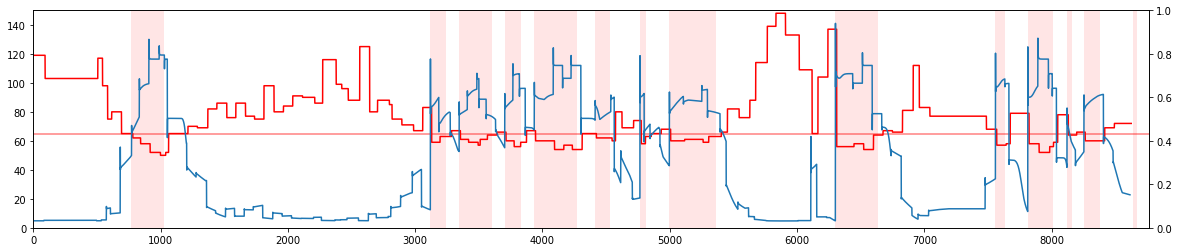

90/90 [==============================] - 1s 14ms/step
Print error: 6360	0.3728827669765099	


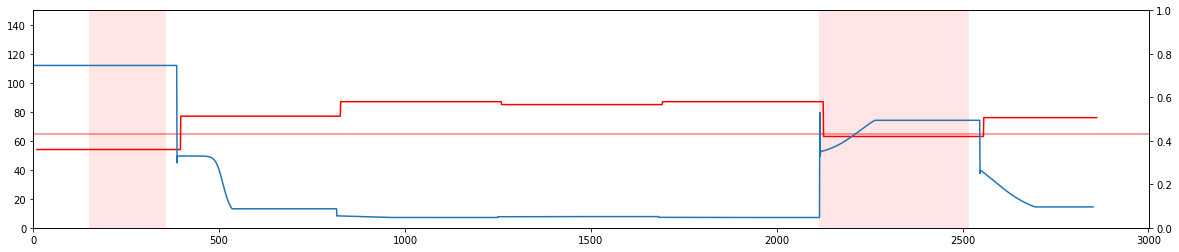

89/89 [==============================] - 1s 15ms/step
Print error: 6385	0.40357671166348663	


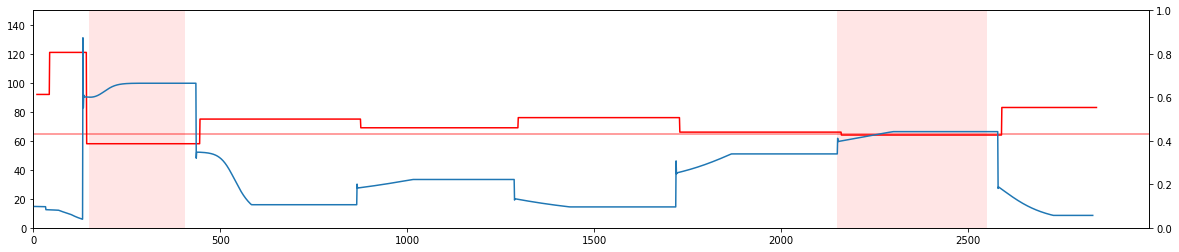

In [16]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('Print error:', '{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()